In [3]:
import os
import pandas as pd
import shutil

# Data PreProcessing

## Directories Management

In [4]:
os.mkdir('/kaggle/working/full_image')

In [5]:
def move_to_images(path, dest_dir):
    images = sorted(os.listdir(path))
    for i in images:
        try:
            shutil.move(os.path.join(path, i), dest_dir)
        except OSError:
            pass
        
        
move_to_images('/kaggle/input/skin-cancer/imgs_part_1/imgs_part_1', '/kaggle/working/full_image')
move_to_images('/kaggle/input/skin-cancer/imgs_part_2/imgs_part_2', '/kaggle/working/full_image')
move_to_images('/kaggle/input/skin-cancer/imgs_part_3/imgs_part_3', '/kaggle/working/full_image')

## Loading Data

In [6]:
# Reading metadata file
data = pd.read_csv('/kaggle/input/skin-cancer/metadata.csv')
data.head()

patient_id  lesion_id  smoke  drink background_father background_mother  \
0   PAT_1516       1765    NaN    NaN               NaN               NaN   
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
2   PAT_1545       1867    NaN    NaN               NaN               NaN   
3   PAT_1989       4061    NaN    NaN               NaN               NaN   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0    8       NaN     NaN                 NaN  ...        NaN        NEV   
1   55     False  FEMALE                True  ...        5.0        BCC   
2   77       NaN     NaN                 NaN  ...        NaN        ACK   
3   75       NaN     NaN                 NaN  ...        NaN        ACK   
4   79     False    MALE                True  ...        5.0        BCC   

    itch   grew   hurt  changed  bleed elevation                 img_id  \
0  FALSE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1516_1765_530.png   
1   TRUE   TRUE  FALSE     TRUE   TRUE      TRUE     PAT_46_881_939.png   
2   TRUE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1545_1867_547.png   
3   TRUE  FALSE  FALSE    FALSE  FALSE     FALSE  PAT_1989_4061_934.png   
4   TRUE   TRUE  FALSE    FALSE   TRUE      TRUE   PAT_684_1302_588.png   

  biopsed  
0   False  
1    True  
2   False  
3   False  
4    True  

[5 rows x 26 columns]

## Label Encoding

In [7]:
# look-up table
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# Replace Classes names with 1, 2, 3, 4, 5
# a function for encoding classes
def create_class(X):
    if X == 'BCC':
        return 0
    elif X =='ACK':
        return 1
    elif X == 'NEV':
        return 2
    elif X == 'SEK':
        return 3
    elif X == 'SCC':
        return 4
    elif X == 'MEL':
        return 5
    else:
        print('error class')
        
        
# applying the function and dropped 'diagnostic' feature because of this can lead to overfit (the target leakage problem)

data['encoded_class'] = data['diagnostic'].apply(create_class)
data.drop(['diagnostic'], axis = 1, inplace = True)
data.sort_values(by ='patient_id', ascending = True, inplace = True, ignore_index = True)

## Handeling Null Values

In [8]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def fill_missing_values_with_regression(data):
    """
    Function to fill all missing values in a DataFrame using regression techniques.
    Uses RandomForestRegressor for numeric features and RandomForestClassifier for categorical features.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing missing values to fill.
    
    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    # Separate numerical and categorical columns
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data.select_dtypes(include=['object', 'bool']).columns

    # Iterate over each column with missing values
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            # Determine if the column is numeric or categorical
            if column in numeric_cols:
                # Handling numeric columns with regression
                model = RandomForestRegressor(n_estimators=100, random_state=42)
            elif column in categorical_cols:
                # Handling categorical columns with classification
                model = RandomForestClassifier(n_estimators=100, random_state=42)
            else:
                # Skip columns that don't match the above types
                continue

            # Splitting data into training and test sets for the column
            df_missing = data[data[column].isnull()]
            df_non_missing = data[data[column].notnull()]

            # Prepare training data
            X_train = df_non_missing.drop(columns=[column])
            y_train = df_non_missing[column]

            # Prepare test data
            X_test = df_missing.drop(columns=[column])

            # Find the indices of categorical columns in X_train
            categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols if col in X_train.columns]

            # Encoding categorical features using OneHotEncoder
            column_transformer = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_indices)
                ], remainder='passthrough'
            )

            # Create an imputer to handle missing values in features
            imputer = SimpleImputer(strategy='most_frequent')

            # Creating a pipeline to handle preprocessing, imputation, and model training
            pipeline = Pipeline(steps=[
                ('imputer', imputer),  # Handle missing values in features
                ('preprocessor', column_transformer),
                ('model', model)
            ])

            # Encoding categorical targets if applicable
            if column in categorical_cols:
                le = LabelEncoder()
                y_train = le.fit_transform(y_train.astype(str))  # Ensure y_train is a string

            # Train the model with the pipeline
            pipeline.fit(X_train, y_train)

            # Predict missing values
            y_pred = pipeline.predict(X_test)

            # If the column is categorical, inverse transform the predictions
            if column in categorical_cols:
                y_pred = le.inverse_transform(y_pred.astype(int))

            # Fill in the missing values in the original dataframe
            data.loc[data[column].isnull(), column] = y_pred

    return data

# Usage
# Assuming 'data' is the DataFrame as defined in your code snippet
data_filled = fill_missing_values_with_regression(data)

# Display the filled DataFrame using pandas functionality
print(data_filled.head())

# If you want a more thorough check
print(data_filled.info())

# Save the data if required for further exploration
data_filled.to_csv("filled_skin_cancer_data.csv", index=False)


  patient_id  lesion_id  smoke  drink background_father background_mother  \
0     PAT_10         18   True  False           GERMANY           GERMANY   
1    PAT_100        393  False  False         POMERANIA         POMERANIA   
2    PAT_100        393  False  False         POMERANIA         POMERANIA   
3   PAT_1000         31  False  False         POMERANIA         POMERANIA   
4   PAT_1006         53  False  False         POMERANIA         POMERANIA   

   age pesticide gender skin_cancer_history  ... diameter_2   itch   grew  \
0   69     False   MALE               False  ...       9.00   TRUE    UNK   
1   14     False   MALE               False  ...       3.00  FALSE  FALSE   
2   14     False   MALE               False  ...       3.00  FALSE  FALSE   
3   65     False   MALE               False  ...       5.87  FALSE  FALSE   
4   63     False   MALE               False  ...       5.69  FALSE  FALSE   

    hurt changed  bleed  elevation               img_id biopsed encoded_cl

In [9]:
data = data_filled

In [10]:
# Creating full links of images 
links = '/kaggle/working/full_image/' + data['img_id']

### Features Extraction

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def encode_categorical_columns(data):
    """
    Encode categorical columns with LabelEncoder.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing categorical columns to encode.
    
    Returns:
    pd.DataFrame: DataFrame with categorical columns encoded.
    """
    label_encoders = {}
    for column in data.select_dtypes(include=['object', 'bool']).columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column].astype(str))
        label_encoders[column] = le
    return data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def drop_low_correlation_features(data, target_column, threshold=0.1, annotate=False):
    """
    Drop features with a correlation to the target column below a certain threshold.
    Visualize the correlation of all features with the target column.
    
    Parameters:
    data (pd.DataFrame): DataFrame with encoded columns.
    target_column (str): The name of the target column to correlate with.
    threshold (float): The correlation threshold below which features will be dropped.
    annotate (bool): Whether or not to annotate the heatmap with correlation values.
    
    Returns:
    pd.DataFrame: DataFrame with low-correlation columns dropped.
    """
    # Correlation matrix
    corr_matrix = data.corr()

    # Extract correlations with the target column
    target_corr = corr_matrix[target_column].drop(target_column)  # Exclude self-correlation

    # Sort correlations by absolute value
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

    # Improved visualization focusing only on correlation with target column
    plt.figure(figsize=(10, 8))
    sns.heatmap(target_corr_sorted.to_frame(), annot=True, cmap='coolwarm', center=0, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Correlation of Features with {target_column}", fontsize=16)
    plt.tight_layout()
    plt.savefig('feature_correlation_barplot.pdf', format='pdf', dpi=300)
    plt.show()

    # Identifying low-correlation columns
    low_corr_columns = target_corr[abs(target_corr) < threshold].index.tolist()

    # Print low correlation columns
    print("Columns with low correlation to the target:", low_corr_columns)

    # Drop low-correlation columns, except the target column itself
    data_dropped = data.drop(columns=low_corr_columns)
    
    return data_dropped


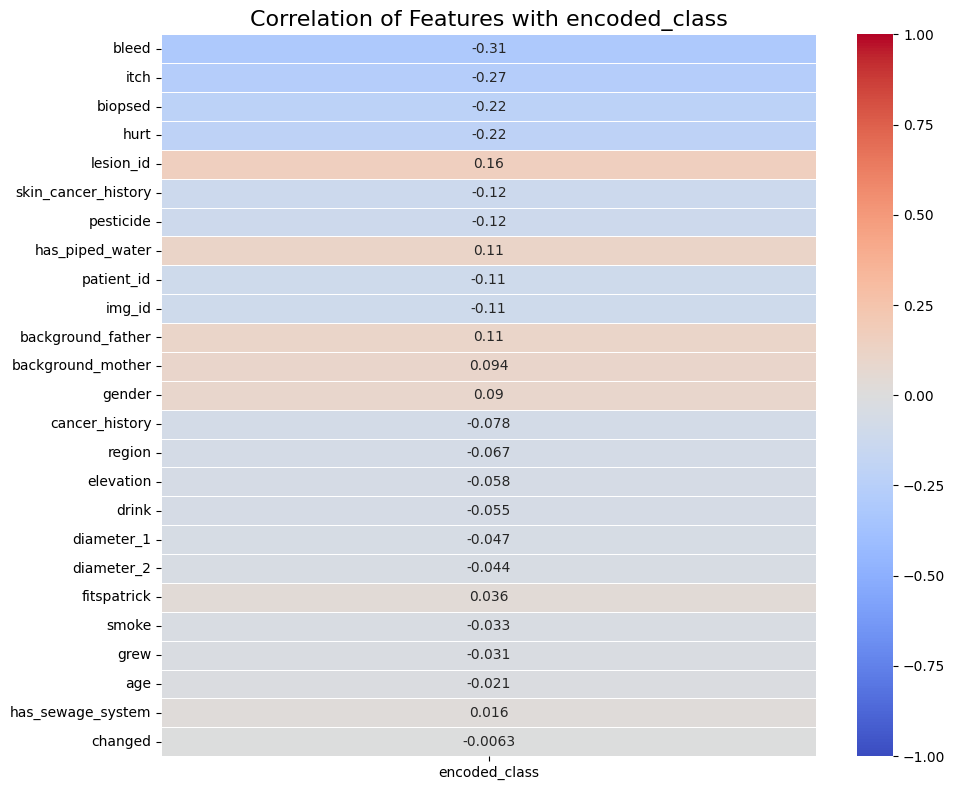

Columns with low correlation to the target: ['smoke', 'drink', 'background_mother', 'age', 'gender', 'cancer_history', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'grew', 'changed', 'elevation']


In [14]:
# Usage example:
# Assuming 'data_encoded' is the DataFrame with encoded columns and 'encoded_class' is the target variable.
target_column = 'encoded_class'
data_final = drop_low_correlation_features(encode_categorical_columns(data), target_column, threshold=0.1, annotate=True)

In [15]:
data = data_final
data.head()

patient_id  lesion_id  background_father  pesticide  skin_cancer_history  \
0           0         18                  4          0                    0   
1           1        393                  9          0                    0   
2           1        393                  9          0                    0   
3           2         31                  9          0                    0   
4           3         53                  9          0                    0   

   has_piped_water  itch  hurt  bleed  img_id  biopsed  encoded_class  
0                1     1     0      0      90        1              4  
1                0     0     0      0       4        1              2  
2                0     0     0      0       5        1              2  
3                1     0     0      0       0        0              3  
4                1     0     0      0       2        0              1

In [16]:
data['image_address'] = links

## Split

## Images Featues Extraction

In [20]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from sklearn.decomposition import PCA
from tqdm import tqdm

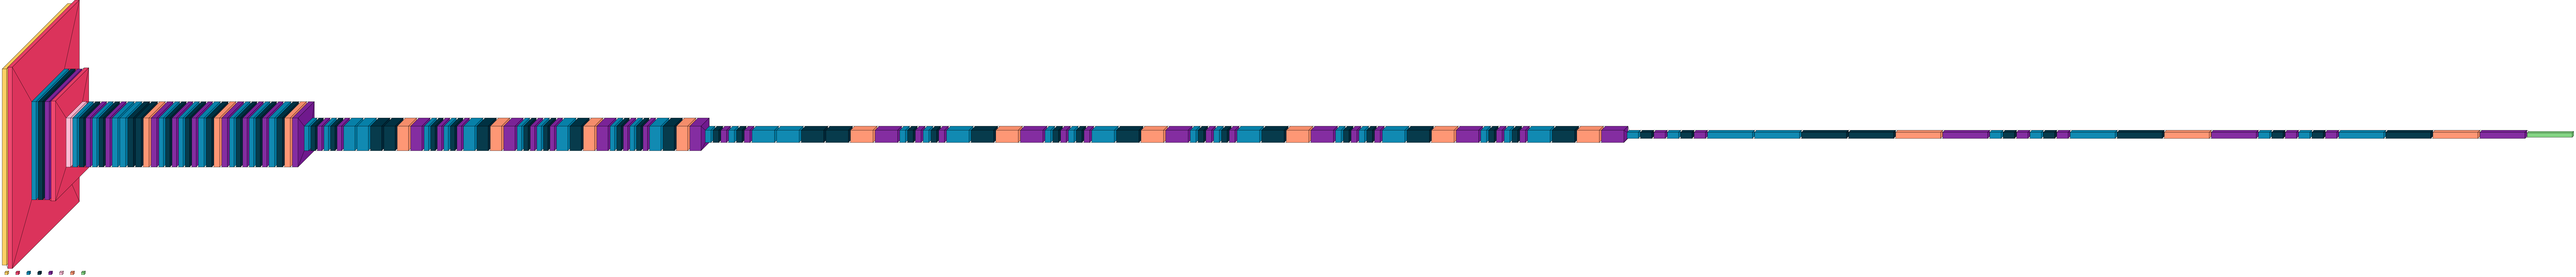

In [38]:
from tensorflow.keras.applications import ResNet50
import visualkeras

# Specify an explicit input shape when loading the model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Use visualkeras to visualize the model
visualkeras.layered_view(base_model, legend=True)


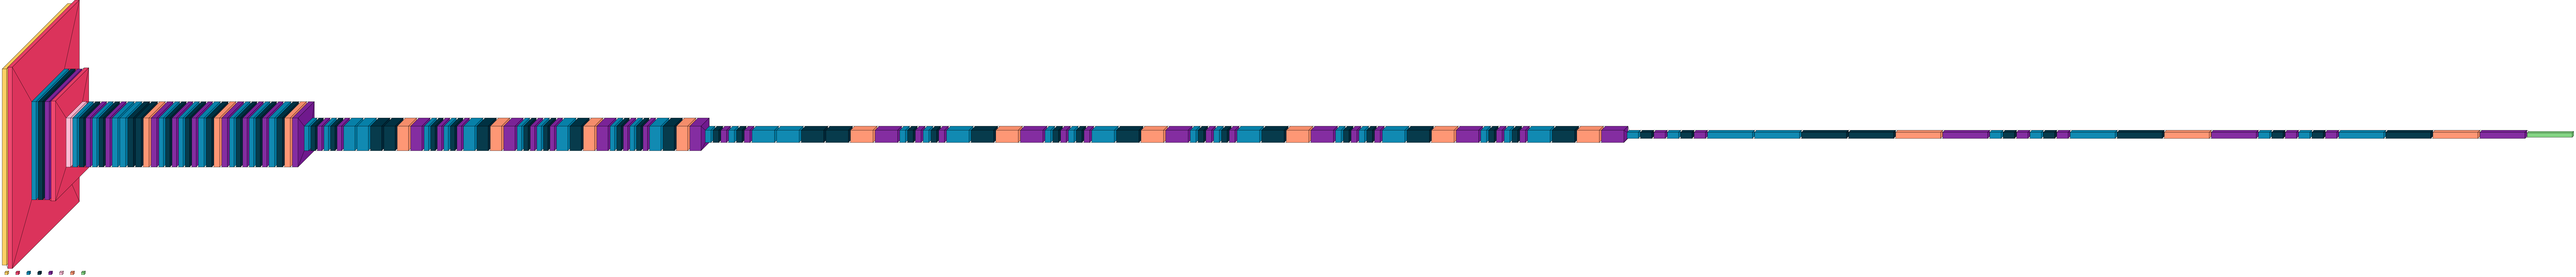

In [40]:
from PIL import ImageFont, ImageDraw
import visualkeras

font = ImageFont.load_default()

# Use visualkeras to visualize the model
visualkeras.layered_view(base_model, legend=True, font=font, to_file='model.pdf')


In [27]:
# !pip install git+https://github.com/paulgavrikov/visualkeras

In [41]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Load an image from path and preprocess it to make it suitable for ResNet50.
    
    Parameters:
    img_path (str): Path to the image file.
    target_size (tuple): Target size to resize the image.
    
    Returns:
    np.array: Preprocessed image ready for feature extraction.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [42]:
def extract_features(data, image_column):
    """
    Extract features for all images in the given DataFrame using a pre-trained ResNet50 model.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing paths to images.
    image_column (str): The column name containing the image file paths.
    
    Returns:
    np.array: Numpy array of extracted features for all images.
    """
    feature_list = []

    for img_path in tqdm(data[image_column], desc="Extracting Features"):
        # Skip the row if the image doesn't exist
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            feature_list.append(np.full((2048,), np.nan))  # Fill with NaNs if image is missing
            continue

        # Load and preprocess the image
        img = load_and_preprocess_image(img_path)

        # Extract features using the ResNet50 model
        feature = base_model.predict(img)
        feature_list.append(feature.flatten())

    return np.array(feature_list)

In [25]:
# data_features = extract_features(data, 'image_address')

Extracting Features:   0%|          | 0/2298 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   0%|          | 1/2298 [00:00<03:59,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 3/2298 [00:00<02:51, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 5/2298 [00:00<02:41, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 7/2298 [00:00<02:41, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 9/2298 [00:00<03:21, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 11/2298 [00:00<03:32, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   1%|          | 13/2298 [00:01<04:01,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 15/2298 [00:01<03:37, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 17/2298 [00:01<03:17, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   1%|          | 19/2298 [00:01<03:01, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   1%|          | 21/2298 [00:01<02:53, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 23/2298 [00:01<02:49, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 25/2298 [00:02<02:43, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 27/2298 [00:02<02:44, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|▏         | 29/2298 [00:02<02:45, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|▏         | 31/2298 [00:02<02:42, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 33/2298 [00:02<02:47, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 35/2298 [00:02<02:51, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 37/2298 [00:02<02:54, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 39/2298 [00:03<02:50, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 41/2298 [00:03<02:50, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 43/2298 [00:03<03:06, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 45/2298 [00:03<03:14, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 47/2298 [00:03<03:02, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 49/2298 [00:03<02:51, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 51/2298 [00:04<02:45, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 53/2298 [00:04<02:39, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   2%|▏         | 55/2298 [00:04<02:34, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   2%|▏         | 57/2298 [00:04<02:33, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 59/2298 [00:04<02:32, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 61/2298 [00:04<02:35, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 63/2298 [00:04<02:38, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 65/2298 [00:04<02:41, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 67/2298 [00:05<02:39, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 69/2298 [00:05<02:39, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 71/2298 [00:05<02:42, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 73/2298 [00:05<02:39, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 75/2298 [00:05<02:56, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 77/2298 [00:05<03:06, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 79/2298 [00:06<03:51,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 81/2298 [00:06<03:28, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▎         | 83/2298 [00:06<03:12, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 85/2298 [00:06<03:05, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 87/2298 [00:06<02:53, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 89/2298 [00:06<02:46, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 91/2298 [00:07<02:39, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   4%|▍         | 93/2298 [00:07<03:50,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 95/2298 [00:07<03:38, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 97/2298 [00:07<03:30, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 99/2298 [00:07<03:30, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   4%|▍         | 101/2298 [00:08<03:20, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 103/2298 [00:08<03:11, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 105/2298 [00:08<03:07, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 107/2298 [00:08<02:57, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 109/2298 [00:08<03:16, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 111/2298 [00:09<03:37, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 113/2298 [00:09<03:26, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 115/2298 [00:09<03:29, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 117/2298 [00:09<03:27, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 119/2298 [00:09<03:25, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 121/2298 [00:09<03:11, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 123/2298 [00:10<03:06, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 125/2298 [00:10<02:59, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 127/2298 [00:10<02:59, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 129/2298 [00:10<02:58, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 131/2298 [00:10<02:56, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 133/2298 [00:10<03:19, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 135/2298 [00:11<03:11, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 137/2298 [00:11<03:24, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 139/2298 [00:11<03:35, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 141/2298 [00:11<03:56,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 143/2298 [00:12<03:37,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 145/2298 [00:12<03:21, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 147/2298 [00:12<03:14, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   6%|▋         | 149/2298 [00:12<03:04, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 151/2298 [00:12<03:15, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 153/2298 [00:12<03:36,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 155/2298 [00:13<03:19, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 157/2298 [00:13<03:49,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 159/2298 [00:13<03:34,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 161/2298 [00:13<03:23, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   7%|▋         | 163/2298 [00:13<03:18, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 165/2298 [00:14<03:23, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 167/2298 [00:14<03:49,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 169/2298 [00:14<03:35,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 171/2298 [00:14<03:22, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 173/2298 [00:14<03:06, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 175/2298 [00:14<02:56, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 177/2298 [00:15<03:15, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 179/2298 [00:15<03:12, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 181/2298 [00:15<03:09, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 183/2298 [00:15<03:19, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 185/2298 [00:15<03:20, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 187/2298 [00:16<03:08, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 189/2298 [00:16<04:05,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 191/2298 [00:16<04:14,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 193/2298 [00:16<03:45,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 195/2298 [00:17<04:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   9%|▊         | 196/2298 [00:17<04:18,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   9%|▊         | 197/2298 [00:17<04:21,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 199/2298 [00:17<03:52,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 201/2298 [00:17<03:21, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 203/2298 [00:17<03:07, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 205/2298 [00:18<03:15, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 207/2298 [00:18<03:48,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 209/2298 [00:18<03:36,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 211/2298 [00:18<03:37,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 212/2298 [00:18<03:37,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 213/2298 [00:19<05:17,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 214/2298 [00:19<05:33,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 215/2298 [00:19<05:59,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   9%|▉         | 216/2298 [00:19<07:30,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 217/2298 [00:20<07:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 219/2298 [00:20<05:13,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 220/2298 [00:20<05:44,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|▉         | 221/2298 [00:20<05:43,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 223/2298 [00:21<05:44,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 225/2298 [00:21<05:05,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 227/2298 [00:21<05:05,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 228/2298 [00:21<05:19,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 229/2298 [00:21<05:37,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 230/2298 [00:22<05:13,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 231/2298 [00:22<04:48,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 233/2298 [00:22<03:44,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 235/2298 [00:22<03:41,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 237/2298 [00:22<03:44,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 238/2298 [00:22<03:48,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 240/2298 [00:22<03:15, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  11%|█         | 242/2298 [00:23<02:52, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 244/2298 [00:23<02:47, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 246/2298 [00:23<02:36, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 248/2298 [00:23<02:32, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 250/2298 [00:23<03:03, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 252/2298 [00:23<03:13, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 254/2298 [00:24<03:07, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 256/2298 [00:24<03:01, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 258/2298 [00:24<02:50, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█▏        | 260/2298 [00:24<02:43, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  11%|█▏        | 262/2298 [00:24<02:44, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█▏        | 264/2298 [00:24<02:52, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 266/2298 [00:25<02:49, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 268/2298 [00:25<02:48, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 270/2298 [00:25<02:50, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 272/2298 [00:25<03:25,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 274/2298 [00:25<03:26,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 276/2298 [00:26<04:12,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 278/2298 [00:26<03:41,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 280/2298 [00:26<03:24,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 282/2298 [00:26<03:09, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 284/2298 [00:26<03:14, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 286/2298 [00:27<03:03, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 288/2298 [00:27<02:57, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  13%|█▎        | 290/2298 [00:27<02:53, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 292/2298 [00:27<02:43, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 294/2298 [00:27<02:37, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  13%|█▎        | 296/2298 [00:27<02:29, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  13%|█▎        | 298/2298 [00:28<02:28, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 300/2298 [00:28<03:35,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 302/2298 [00:28<05:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 303/2298 [00:29<06:12,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 304/2298 [00:29<07:02,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 305/2298 [00:29<07:43,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 306/2298 [00:29<06:45,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 308/2298 [00:30<04:51,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 310/2298 [00:30<03:52,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▎        | 312/2298 [00:30<03:18, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 314/2298 [00:30<03:36,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 316/2298 [00:30<03:52,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 317/2298 [00:31<04:14,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 318/2298 [00:31<04:11,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 320/2298 [00:31<04:08,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 321/2298 [00:31<04:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 322/2298 [00:31<04:01,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 323/2298 [00:31<04:09,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 325/2298 [00:31<03:28,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 326/2298 [00:32<03:39,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 328/2298 [00:32<03:08, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 330/2298 [00:32<04:15,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 331/2298 [00:32<04:44,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 332/2298 [00:33<04:49,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 333/2298 [00:33<04:41,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 335/2298 [00:33<03:46,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 337/2298 [00:33<03:10, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 339/2298 [00:33<02:53, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 341/2298 [00:33<02:40, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 343/2298 [00:33<02:39, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 345/2298 [00:34<02:59, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 347/2298 [00:34<02:53, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 349/2298 [00:34<03:03, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 351/2298 [00:34<03:02, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 353/2298 [00:34<03:19,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  15%|█▌        | 355/2298 [00:35<02:58, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 357/2298 [00:35<03:11, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 359/2298 [00:35<03:29,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 360/2298 [00:35<03:51,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 362/2298 [00:35<03:19,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 364/2298 [00:35<02:59, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 366/2298 [00:36<02:46, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 368/2298 [00:36<02:39, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 370/2298 [00:36<02:31, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 372/2298 [00:36<02:29, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  16%|█▋        | 374/2298 [00:36<02:21, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▋        | 376/2298 [00:36<02:20, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 378/2298 [00:36<02:17, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  17%|█▋        | 380/2298 [00:37<02:15, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 382/2298 [00:37<02:23, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 384/2298 [00:37<03:21,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 386/2298 [00:37<03:36,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 388/2298 [00:38<03:46,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 389/2298 [00:38<03:54,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 390/2298 [00:38<04:21,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 391/2298 [00:38<04:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 393/2298 [00:38<03:58,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 394/2298 [00:39<04:39,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 395/2298 [00:39<05:20,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 396/2298 [00:39<05:11,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 398/2298 [00:39<04:06,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 399/2298 [00:39<04:08,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 401/2298 [00:39<03:40,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 402/2298 [00:40<03:38,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 403/2298 [00:40<04:11,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  18%|█▊        | 405/2298 [00:40<03:41,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 407/2298 [00:40<03:15,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 409/2298 [00:40<02:57, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 411/2298 [00:40<02:48, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 413/2298 [00:41<03:00, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 415/2298 [00:41<03:10,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 417/2298 [00:41<03:03, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 419/2298 [00:41<03:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 420/2298 [00:42<04:24,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 422/2298 [00:42<03:58,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 424/2298 [00:42<03:29,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 425/2298 [00:42<03:39,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  19%|█▊        | 427/2298 [00:42<03:11,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▊        | 429/2298 [00:42<02:57, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 431/2298 [00:43<02:48, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 433/2298 [00:43<02:40, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 435/2298 [00:43<02:42, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 437/2298 [00:43<02:34, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 439/2298 [00:43<02:31, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 441/2298 [00:43<02:45, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 443/2298 [00:44<02:38, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 445/2298 [00:44<02:56, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 447/2298 [00:44<02:52, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 449/2298 [00:44<02:58, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 451/2298 [00:44<02:45, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 453/2298 [00:44<02:35, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|█▉        | 455/2298 [00:45<02:32, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 457/2298 [00:45<02:29, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 459/2298 [00:45<02:27, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 461/2298 [00:45<02:34, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 463/2298 [00:45<03:09,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  20%|██        | 465/2298 [00:46<02:51, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 467/2298 [00:46<02:54, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 469/2298 [00:46<03:14,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 471/2298 [00:46<03:02,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 473/2298 [00:46<03:00, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 475/2298 [00:47<02:50, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 477/2298 [00:47<02:34, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 479/2298 [00:47<02:30, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 481/2298 [00:47<02:36, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 483/2298 [00:47<02:34, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 485/2298 [00:47<02:55, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 487/2298 [00:48<02:41, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 489/2298 [00:48<02:36, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██▏       | 491/2298 [00:48<02:39, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 493/2298 [00:48<02:35, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 495/2298 [00:48<02:27, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 497/2298 [00:48<02:16, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  22%|██▏       | 499/2298 [00:49<02:12, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  22%|██▏       | 501/2298 [00:49<02:10, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 503/2298 [00:49<02:32, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 505/2298 [00:49<02:41, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 507/2298 [00:49<03:13,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 509/2298 [00:50<02:58, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  22%|██▏       | 511/2298 [00:50<02:49, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  22%|██▏       | 513/2298 [00:50<02:35, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 515/2298 [00:50<02:33, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 517/2298 [00:50<02:26, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 519/2298 [00:50<02:19, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 521/2298 [00:50<02:16, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  23%|██▎       | 523/2298 [00:51<02:20, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 525/2298 [00:51<02:24, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 527/2298 [00:51<03:44,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 529/2298 [00:52<03:50,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 531/2298 [00:52<03:15,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 533/2298 [00:52<03:00,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 535/2298 [00:52<02:58,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 537/2298 [00:52<02:38, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 539/2298 [00:52<02:24, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 541/2298 [00:52<02:20, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 543/2298 [00:53<02:16, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▎       | 545/2298 [00:53<02:14, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 547/2298 [00:53<02:11, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 549/2298 [00:53<02:07, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 551/2298 [00:53<02:08, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 553/2298 [00:53<02:13, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 555/2298 [00:54<02:22, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 557/2298 [00:54<02:19, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 559/2298 [00:54<02:22, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 561/2298 [00:54<02:18, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 563/2298 [00:54<02:26, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 565/2298 [00:54<02:16, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 567/2298 [00:54<02:18, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 569/2298 [00:55<02:11, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  25%|██▍       | 571/2298 [00:55<02:07, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 573/2298 [00:55<03:23,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 575/2298 [00:55<03:12,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  25%|██▌       | 577/2298 [00:56<03:23,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 579/2298 [00:56<03:12,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 581/2298 [00:56<02:55,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 583/2298 [00:56<02:48, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 585/2298 [00:56<02:49, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 587/2298 [00:57<02:38, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 589/2298 [00:57<02:50, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting Features:  26%|██▌       | 591/2298 [00:57<02:53,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 593/2298 [00:57<02:47, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 595/2298 [00:57<02:52,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 597/2298 [00:58<02:37, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 599/2298 [00:58<02:31, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 601/2298 [00:58<02:48, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 603/2298 [00:58<02:55,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 605/2298 [00:58<03:28,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▋       | 607/2298 [00:59<03:08,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  27%|██▋       | 609/2298 [00:59<02:44, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 611/2298 [00:59<02:34, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  27%|██▋       | 613/2298 [00:59<02:29, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 615/2298 [00:59<02:21, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 617/2298 [00:59<02:15, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  27%|██▋       | 619/2298 [01:00<02:12, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 621/2298 [01:00<02:08, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 623/2298 [01:00<02:20, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 625/2298 [01:00<02:29, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 627/2298 [01:00<02:21, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  27%|██▋       | 629/2298 [01:01<02:47,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 631/2298 [01:01<03:06,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 632/2298 [01:01<03:06,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 633/2298 [01:01<03:08,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 634/2298 [01:01<03:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 636/2298 [01:01<02:56,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 638/2298 [01:02<02:53,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 639/2298 [01:02<03:05,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 640/2298 [01:02<03:05,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 641/2298 [01:02<03:03,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 642/2298 [01:02<03:08,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 643/2298 [01:02<03:15,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 644/2298 [01:02<03:24,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 646/2298 [01:02<02:56,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  28%|██▊       | 648/2298 [01:03<02:35, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 650/2298 [01:03<02:38, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 652/2298 [01:03<02:59,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 654/2298 [01:03<03:02,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 655/2298 [01:03<03:02,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  29%|██▊       | 657/2298 [01:04<02:40, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 659/2298 [01:04<02:28, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 661/2298 [01:04<02:19, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 663/2298 [01:04<02:15, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 665/2298 [01:04<02:10, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 667/2298 [01:04<02:04, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  29%|██▉       | 669/2298 [01:04<01:59, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 671/2298 [01:05<02:08, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 673/2298 [01:05<02:32, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 675/2298 [01:05<03:15,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 677/2298 [01:05<03:16,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  30%|██▉       | 679/2298 [01:06<03:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 681/2298 [01:06<02:56,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  30%|██▉       | 683/2298 [01:06<02:40, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 685/2298 [01:06<02:39, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 687/2298 [01:06<02:37, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  30%|██▉       | 689/2298 [01:07<02:36, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  30%|███       | 691/2298 [01:07<02:24, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  30%|███       | 693/2298 [01:07<02:25, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 695/2298 [01:07<02:21, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 697/2298 [01:07<02:12, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 699/2298 [01:07<02:12, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 701/2298 [01:08<02:14, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 703/2298 [01:08<02:19, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 705/2298 [01:08<02:10, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 707/2298 [01:08<02:17, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 709/2298 [01:08<02:24, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 711/2298 [01:09<02:33, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 713/2298 [01:09<02:25, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 715/2298 [01:09<02:25, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 717/2298 [01:09<02:21, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 719/2298 [01:09<02:44,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 721/2298 [01:10<03:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 723/2298 [01:10<03:04,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 724/2298 [01:10<03:04,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 726/2298 [01:10<02:47,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 728/2298 [01:10<02:48,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 730/2298 [01:11<02:32, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 732/2298 [01:11<02:20, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 734/2298 [01:11<02:20, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 736/2298 [01:11<02:25, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 738/2298 [01:11<02:25, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 740/2298 [01:11<02:31, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 742/2298 [01:12<03:16,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 743/2298 [01:12<03:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 744/2298 [01:12<03:21,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 745/2298 [01:12<03:15,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 747/2298 [01:12<02:40,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 749/2298 [01:13<02:34, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 751/2298 [01:13<02:35,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 753/2298 [01:13<02:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 755/2298 [01:13<02:21, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 757/2298 [01:13<02:12, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 759/2298 [01:13<02:24, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 761/2298 [01:14<02:23, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 763/2298 [01:14<02:25, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  33%|███▎      | 765/2298 [01:14<02:43,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 767/2298 [01:14<02:26, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 769/2298 [01:14<02:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▎      | 771/2298 [01:15<02:16, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▎      | 773/2298 [01:15<02:19, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 775/2298 [01:15<02:10, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 777/2298 [01:15<02:06, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 779/2298 [01:15<02:08, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 781/2298 [01:15<02:01, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 783/2298 [01:16<01:58, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 785/2298 [01:16<01:56, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 787/2298 [01:16<01:51, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 789/2298 [01:16<01:59, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 791/2298 [01:16<01:59, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 793/2298 [01:16<02:00, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 795/2298 [01:16<01:58, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 797/2298 [01:17<01:54, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 799/2298 [01:17<02:01, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 801/2298 [01:17<02:18, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 803/2298 [01:17<02:32,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 805/2298 [01:17<02:24, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 807/2298 [01:18<02:28, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 809/2298 [01:18<02:27, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▌      | 811/2298 [01:18<02:14, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▌      | 813/2298 [01:18<02:04, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 815/2298 [01:18<02:02, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 817/2298 [01:18<02:03, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 819/2298 [01:19<02:06, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 821/2298 [01:19<02:04, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 823/2298 [01:19<02:11, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 825/2298 [01:19<02:05, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 827/2298 [01:19<02:02, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 829/2298 [01:20<02:25, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 831/2298 [01:20<02:11, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 833/2298 [01:20<02:08, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▋      | 835/2298 [01:20<01:59, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▋      | 837/2298 [01:20<02:03, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 839/2298 [01:20<02:04, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 841/2298 [01:21<02:00, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 843/2298 [01:21<01:59, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 845/2298 [01:21<02:42,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 847/2298 [01:21<02:30,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 849/2298 [01:22<02:43,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 851/2298 [01:22<02:44,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 853/2298 [01:22<02:30,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 855/2298 [01:22<02:27,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 857/2298 [01:22<02:28,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 859/2298 [01:23<02:34,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 861/2298 [01:23<02:32,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 862/2298 [01:23<02:37,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 864/2298 [01:23<02:22, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 866/2298 [01:23<02:09, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 868/2298 [01:23<02:15, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 870/2298 [01:24<02:16, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 872/2298 [01:24<02:34,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 874/2298 [01:24<02:19, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 876/2298 [01:24<02:10, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 878/2298 [01:24<02:30,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 880/2298 [01:25<03:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 882/2298 [01:25<02:41,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 884/2298 [01:25<02:21,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▊      | 886/2298 [01:25<02:08, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 888/2298 [01:26<03:04,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 889/2298 [01:26<03:01,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 891/2298 [01:26<02:47,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 892/2298 [01:26<02:46,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 893/2298 [01:26<02:41,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 895/2298 [01:27<02:59,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 897/2298 [01:27<02:34,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 899/2298 [01:27<02:19, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 901/2298 [01:27<02:22,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 903/2298 [01:27<02:24,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 905/2298 [01:27<02:21,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 907/2298 [01:28<02:26,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 908/2298 [01:28<02:26,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|███▉      | 909/2298 [01:28<02:31,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  40%|███▉      | 910/2298 [01:28<02:35,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 912/2298 [01:28<02:24,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|███▉      | 913/2298 [01:28<02:23,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 914/2298 [01:28<02:24,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 916/2298 [01:29<02:27,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 917/2298 [01:29<02:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 919/2298 [01:29<02:33,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 920/2298 [01:29<02:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 922/2298 [01:29<02:50,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 923/2298 [01:30<02:56,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 925/2298 [01:30<02:31,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 926/2298 [01:30<02:39,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 927/2298 [01:30<03:06,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 928/2298 [01:30<03:07,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 930/2298 [01:30<02:39,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 932/2298 [01:31<02:28,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 933/2298 [01:31<02:32,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 934/2298 [01:31<02:29,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 935/2298 [01:31<02:29,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 937/2298 [01:31<02:16,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 939/2298 [01:31<02:04, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  41%|████      | 941/2298 [01:31<02:00, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 943/2298 [01:32<02:09, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 945/2298 [01:32<02:22,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 947/2298 [01:32<02:16,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████▏     | 949/2298 [01:32<02:08, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████▏     | 951/2298 [01:33<02:26,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 953/2298 [01:33<02:27,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 954/2298 [01:33<02:26,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 956/2298 [01:33<02:24,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 958/2298 [01:33<02:11, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 960/2298 [01:33<02:11, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 962/2298 [01:34<02:04, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 964/2298 [01:34<02:13, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 966/2298 [01:34<02:12, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 968/2298 [01:34<02:07, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 970/2298 [01:34<02:14,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 972/2298 [01:35<02:06, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 974/2298 [01:35<02:47,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 975/2298 [01:35<02:43,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 977/2298 [01:35<02:23,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 979/2298 [01:35<02:18,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 981/2298 [01:36<02:14,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 983/2298 [01:36<02:03, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 985/2298 [01:36<01:52, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 987/2298 [01:36<01:47, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 989/2298 [01:36<01:48, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 991/2298 [01:36<01:43, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 993/2298 [01:37<02:31,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 995/2298 [01:37<02:38,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 996/2298 [01:37<02:37,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 997/2298 [01:37<02:49,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 999/2298 [01:37<02:25,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▎     | 1001/2298 [01:38<02:12,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▎     | 1003/2298 [01:38<01:58, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▎     | 1005/2298 [01:38<01:47, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1007/2298 [01:38<01:44, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1009/2298 [01:38<02:08, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 1011/2298 [01:38<01:57, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 1013/2298 [01:39<01:51, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 1015/2298 [01:39<01:55, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 1017/2298 [01:39<01:55, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 1019/2298 [01:39<01:48, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1021/2298 [01:39<02:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 1023/2298 [01:40<02:07, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 1025/2298 [01:40<01:54, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 1027/2298 [01:40<02:10,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  45%|████▍     | 1029/2298 [01:40<02:00, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 1031/2298 [01:40<02:01, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1033/2298 [01:41<01:53, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 1035/2298 [01:41<02:33,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1037/2298 [01:41<02:15,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1039/2298 [01:41<02:18,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 1041/2298 [01:42<02:29,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 1043/2298 [01:42<02:15,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 1045/2298 [01:42<02:09,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▌     | 1047/2298 [01:42<02:06,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▌     | 1049/2298 [01:42<01:53, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  46%|████▌     | 1051/2298 [01:42<01:49, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  46%|████▌     | 1053/2298 [01:43<01:42, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1055/2298 [01:43<01:48, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1057/2298 [01:43<01:46, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1059/2298 [01:43<01:43, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1061/2298 [01:43<01:45, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 1063/2298 [01:44<02:10,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  46%|████▋     | 1065/2298 [01:44<02:12,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▋     | 1067/2298 [01:44<01:58, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1069/2298 [01:44<02:46,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1071/2298 [01:45<02:29,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1073/2298 [01:45<02:28,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1075/2298 [01:45<02:11,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 1077/2298 [01:45<02:02, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 1079/2298 [01:45<01:50, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 1081/2298 [01:45<01:47, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 1083/2298 [01:46<01:40, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 1085/2298 [01:46<01:39, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 1087/2298 [01:46<01:42, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 1089/2298 [01:46<01:41, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 1091/2298 [01:46<01:39, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1093/2298 [01:47<02:00,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1095/2298 [01:47<02:00,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  48%|████▊     | 1097/2298 [01:47<02:09,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1099/2298 [01:47<02:05,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1101/2298 [01:47<02:02,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1103/2298 [01:48<01:52, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1105/2298 [01:48<01:55, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1107/2298 [01:48<02:00,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 1109/2298 [01:48<01:55, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  48%|████▊     | 1111/2298 [01:48<02:02,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 1113/2298 [01:49<02:06,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1114/2298 [01:49<02:31,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 1115/2298 [01:49<02:53,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▊     | 1116/2298 [01:49<03:10,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 1118/2298 [01:49<02:33,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 1120/2298 [01:50<02:07,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1122/2298 [01:50<02:06,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 1124/2298 [01:50<02:02,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  49%|████▉     | 1126/2298 [01:50<01:48, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1128/2298 [01:50<01:57,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 1130/2298 [01:50<01:44, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1132/2298 [01:51<01:44, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1134/2298 [01:51<01:49, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 1136/2298 [01:51<01:40, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  50%|████▉     | 1138/2298 [01:51<01:39, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1140/2298 [01:51<01:37, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1142/2298 [01:51<01:34, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1144/2298 [01:52<01:52, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 1146/2298 [01:52<01:45, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1148/2298 [01:52<02:07,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  50%|█████     | 1150/2298 [01:52<01:52, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1152/2298 [01:53<01:52, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 1154/2298 [01:53<01:41, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1156/2298 [01:53<02:11,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1158/2298 [01:53<01:59,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|█████     | 1160/2298 [01:53<01:51, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 1162/2298 [01:53<01:41, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1164/2298 [01:54<01:37, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1166/2298 [01:54<01:33, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1168/2298 [01:54<01:34, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1170/2298 [01:54<01:37, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 1172/2298 [01:54<01:31, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1174/2298 [01:54<01:30, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 1176/2298 [01:55<01:35, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████▏    | 1178/2298 [01:55<01:31, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████▏    | 1180/2298 [01:55<01:32, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████▏    | 1182/2298 [01:55<01:30, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1184/2298 [01:55<01:40, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  52%|█████▏    | 1186/2298 [01:56<01:48, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 1188/2298 [01:56<01:59,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1190/2298 [01:56<01:45, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1192/2298 [01:56<01:43, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  52%|█████▏    | 1194/2298 [01:56<01:40, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1196/2298 [01:57<02:01,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1197/2298 [01:57<02:00,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1198/2298 [01:57<02:08,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1199/2298 [01:57<02:08,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1200/2298 [01:57<02:08,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1202/2298 [01:57<02:01,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1204/2298 [01:57<01:43, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  52%|█████▏    | 1206/2298 [01:58<01:32, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  53%|█████▎    | 1208/2298 [01:58<01:24, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  53%|█████▎    | 1210/2298 [01:58<01:27, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 1212/2298 [01:58<01:26, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1214/2298 [01:58<01:22, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1216/2298 [01:58<01:38, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  53%|█████▎    | 1218/2298 [01:59<01:40, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1220/2298 [01:59<01:39, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  53%|█████▎    | 1222/2298 [01:59<01:36, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1224/2298 [01:59<01:37, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1226/2298 [01:59<01:35, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1228/2298 [01:59<01:31, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▎    | 1230/2298 [02:00<01:37, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 1232/2298 [02:00<01:32, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  54%|█████▎    | 1234/2298 [02:00<01:33, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1236/2298 [02:00<01:31, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1238/2298 [02:00<01:29, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  54%|█████▍    | 1240/2298 [02:01<01:45, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1242/2298 [02:01<01:42, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1244/2298 [02:01<01:49,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1246/2298 [02:01<01:39, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▍    | 1248/2298 [02:01<01:35, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1250/2298 [02:02<01:36, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1252/2298 [02:02<01:50,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  55%|█████▍    | 1254/2298 [02:02<01:40, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  55%|█████▍    | 1256/2298 [02:02<01:30, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  55%|█████▍    | 1258/2298 [02:02<01:22, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 1260/2298 [02:02<01:29, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1262/2298 [02:03<01:43, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1264/2298 [02:03<01:40, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  55%|█████▌    | 1266/2298 [02:03<01:37, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  55%|█████▌    | 1268/2298 [02:03<01:31, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Extracting Features:  55%|█████▌    | 1270/2298 [02:03<01:24, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 1272/2298 [02:04<01:46,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1274/2298 [02:04<01:40, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1276/2298 [02:04<01:40, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 1278/2298 [02:04<01:37, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  56%|█████▌    | 1280/2298 [02:04<01:27, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 1282/2298 [02:04<01:25, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 1284/2298 [02:05<01:23, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1286/2298 [02:05<01:23, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1288/2298 [02:05<01:48,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1290/2298 [02:05<01:37, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 1292/2298 [02:05<01:33, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▋    | 1294/2298 [02:06<01:38, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▋    | 1296/2298 [02:06<01:42,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 1298/2298 [02:06<02:10,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1299/2298 [02:06<02:10,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1301/2298 [02:07<01:52,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1303/2298 [02:07<01:38, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1305/2298 [02:07<01:31, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1307/2298 [02:07<01:35, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1309/2298 [02:07<01:37, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1311/2298 [02:08<01:51,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1312/2298 [02:08<01:49,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1313/2298 [02:08<01:47,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1315/2298 [02:08<01:43,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1316/2298 [02:08<02:08,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1318/2298 [02:08<01:49,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1320/2298 [02:09<01:43,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1322/2298 [02:09<01:48,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1323/2298 [02:09<01:59,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1325/2298 [02:09<01:50,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1326/2298 [02:09<01:53,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1327/2298 [02:09<02:03,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  58%|█████▊    | 1329/2298 [02:10<01:43,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1331/2298 [02:10<01:29, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1333/2298 [02:10<01:22, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1335/2298 [02:10<01:19, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  58%|█████▊    | 1337/2298 [02:10<01:15, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1339/2298 [02:10<01:31, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1341/2298 [02:11<01:23, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1343/2298 [02:11<01:19, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1345/2298 [02:11<01:18, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1347/2298 [02:11<01:17, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▊    | 1349/2298 [02:11<01:18, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1351/2298 [02:11<01:31, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  59%|█████▉    | 1353/2298 [02:12<01:23, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1355/2298 [02:12<01:28, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1357/2298 [02:12<01:47,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1359/2298 [02:12<01:36,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1361/2298 [02:12<01:26, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1363/2298 [02:13<01:21, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  59%|█████▉    | 1365/2298 [02:13<01:20, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1367/2298 [02:13<01:21, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 1369/2298 [02:13<01:20, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|█████▉    | 1371/2298 [02:13<01:17, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|█████▉    | 1373/2298 [02:13<01:14, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  60%|█████▉    | 1375/2298 [02:13<01:10, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  60%|█████▉    | 1377/2298 [02:14<01:08, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1379/2298 [02:14<01:14, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|██████    | 1381/2298 [02:14<01:13, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 1383/2298 [02:14<01:19, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 1385/2298 [02:14<01:17, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1387/2298 [02:15<01:24, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|██████    | 1389/2298 [02:15<01:18, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1391/2298 [02:15<01:14, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 1393/2298 [02:15<01:11, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 1395/2298 [02:15<01:14, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1397/2298 [02:15<01:13, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 1399/2298 [02:15<01:10, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 1401/2298 [02:16<01:23, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1403/2298 [02:16<01:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1405/2298 [02:16<01:14, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 1407/2298 [02:16<01:11, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████▏   | 1409/2298 [02:16<01:09, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████▏   | 1411/2298 [02:16<01:07, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████▏   | 1413/2298 [02:17<01:07, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  62%|██████▏   | 1415/2298 [02:17<01:11, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 1417/2298 [02:17<01:14, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1419/2298 [02:17<01:16, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1421/2298 [02:17<01:14, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 1423/2298 [02:18<01:20, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 1425/2298 [02:18<01:27, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 1427/2298 [02:18<01:36,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1429/2298 [02:18<01:28,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 1431/2298 [02:18<01:22, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 1433/2298 [02:19<01:23, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  62%|██████▏   | 1435/2298 [02:19<01:16, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  63%|██████▎   | 1437/2298 [02:19<01:11, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 1439/2298 [02:19<01:10, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1441/2298 [02:19<01:07, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 1443/2298 [02:19<01:06, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 1445/2298 [02:19<01:04, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  63%|██████▎   | 1447/2298 [02:20<01:03, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 1449/2298 [02:20<01:27,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1451/2298 [02:20<02:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1452/2298 [02:21<02:11,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1454/2298 [02:21<01:49,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 1456/2298 [02:21<01:34,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1458/2298 [02:21<01:22, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 1460/2298 [02:21<01:31,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▎   | 1462/2298 [02:22<01:22, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 1464/2298 [02:22<01:18, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1466/2298 [02:22<01:11, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1468/2298 [02:22<01:07, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1470/2298 [02:22<01:08, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1472/2298 [02:22<01:10, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1474/2298 [02:23<01:20, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1476/2298 [02:23<01:20, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1478/2298 [02:23<01:15, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1480/2298 [02:23<01:08, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1482/2298 [02:23<01:04, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  65%|██████▍   | 1484/2298 [02:23<01:01, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▍   | 1486/2298 [02:24<01:14, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 1488/2298 [02:24<01:17, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 1490/2298 [02:24<01:14, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 1492/2298 [02:24<01:11, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1494/2298 [02:24<01:07, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1496/2298 [02:24<01:09, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▌   | 1498/2298 [02:25<01:06, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 1500/2298 [02:25<01:09, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 1502/2298 [02:25<01:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 1504/2298 [02:25<01:06, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1506/2298 [02:25<01:07, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  66%|██████▌   | 1508/2298 [02:26<01:15, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1510/2298 [02:26<01:09, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 1512/2298 [02:26<01:06, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1514/2298 [02:26<01:05, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1516/2298 [02:26<01:03, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1518/2298 [02:26<01:08, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1520/2298 [02:26<01:05, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1522/2298 [02:27<01:01, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▋   | 1524/2298 [02:27<01:04, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▋   | 1526/2298 [02:27<01:25,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▋   | 1528/2298 [02:27<01:19,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  67%|██████▋   | 1530/2298 [02:27<01:14, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1532/2298 [02:28<01:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1534/2298 [02:28<01:07, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1536/2298 [02:28<01:08, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1538/2298 [02:28<01:07, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 1540/2298 [02:28<01:11, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1542/2298 [02:29<01:07, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1544/2298 [02:29<01:27,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1546/2298 [02:29<01:27,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1547/2298 [02:29<01:25,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1548/2298 [02:29<01:25,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1550/2298 [02:29<01:16,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1552/2298 [02:30<01:11, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1554/2298 [02:30<01:13, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  68%|██████▊   | 1556/2298 [02:30<01:09, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1558/2298 [02:30<01:10, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 1560/2298 [02:31<01:19,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 1562/2298 [02:31<01:12, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 1564/2298 [02:31<01:13, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 1566/2298 [02:31<01:11, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 1568/2298 [02:31<01:10, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 1570/2298 [02:31<01:12, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 1572/2298 [02:32<01:06, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 1574/2298 [02:32<01:01, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▊   | 1576/2298 [02:32<00:59, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▊   | 1578/2298 [02:32<01:01, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  69%|██████▉   | 1580/2298 [02:32<00:57, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 1582/2298 [02:32<00:56, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 1584/2298 [02:33<01:03, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1586/2298 [02:33<01:03, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 1588/2298 [02:33<01:05, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1590/2298 [02:33<01:02, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▉   | 1592/2298 [02:33<01:01, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1594/2298 [02:33<01:04, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1596/2298 [02:34<01:01, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 1598/2298 [02:34<01:01, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|██████▉   | 1600/2298 [02:34<01:04, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|██████▉   | 1602/2298 [02:34<00:58, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 1604/2298 [02:34<01:00, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|██████▉   | 1606/2298 [02:35<01:02, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 1608/2298 [02:35<00:58, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 1610/2298 [02:35<00:57, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 1612/2298 [02:35<00:57, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 1614/2298 [02:35<00:55, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  70%|███████   | 1616/2298 [02:35<00:53, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 1618/2298 [02:35<00:54, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 1620/2298 [02:36<00:56, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 1622/2298 [02:36<00:53, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 1624/2298 [02:36<00:53, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  71%|███████   | 1626/2298 [02:36<00:53, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 1628/2298 [02:36<00:52, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 1630/2298 [02:37<01:02, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 1632/2298 [02:37<00:59, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 1634/2298 [02:37<00:59, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 1636/2298 [02:37<01:03, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 1638/2298 [02:37<00:58, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 1640/2298 [02:37<00:59, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 1642/2298 [02:38<01:00, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 1644/2298 [02:38<00:59, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 1646/2298 [02:38<01:01, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 1648/2298 [02:38<01:02, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 1650/2298 [02:38<01:10,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 1652/2298 [02:39<01:05,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1654/2298 [02:39<00:58, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 1656/2298 [02:39<00:57, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 1658/2298 [02:39<00:56, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 1660/2298 [02:39<00:56, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1662/2298 [02:40<00:59, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  72%|███████▏  | 1664/2298 [02:40<00:56, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1666/2298 [02:40<00:54, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1668/2298 [02:40<00:52, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 1670/2298 [02:40<00:50, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 1672/2298 [02:40<00:47, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 1674/2298 [02:40<00:49, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  73%|███████▎  | 1676/2298 [02:41<00:48, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 1678/2298 [02:41<00:48, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1680/2298 [02:41<00:50, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1682/2298 [02:41<00:49, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1684/2298 [02:41<00:50, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1686/2298 [02:41<00:55, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  73%|███████▎  | 1688/2298 [02:42<00:53, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  74%|███████▎  | 1690/2298 [02:42<00:50, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▎  | 1692/2298 [02:42<00:58, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 1694/2298 [02:42<00:57, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1696/2298 [02:42<00:55, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 1698/2298 [02:43<00:56, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 1700/2298 [02:43<00:56, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1702/2298 [02:43<00:53, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 1704/2298 [02:43<00:52, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1706/2298 [02:43<00:56, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1708/2298 [02:44<00:58, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1710/2298 [02:44<00:55, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1712/2298 [02:44<00:55, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 1714/2298 [02:44<00:59,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 1716/2298 [02:44<00:56, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 1718/2298 [02:44<00:53, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 1720/2298 [02:45<00:49, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 1722/2298 [02:45<00:47, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 1724/2298 [02:45<00:47, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 1726/2298 [02:45<00:48, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 1728/2298 [02:45<00:49, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 1730/2298 [02:46<00:53, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 1732/2298 [02:46<00:50, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▌  | 1734/2298 [02:46<00:49, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 1736/2298 [02:46<00:47, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1738/2298 [02:46<00:48, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 1740/2298 [02:46<00:49, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 1742/2298 [02:47<00:53, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 1744/2298 [02:47<00:48, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  76%|███████▌  | 1746/2298 [02:47<00:49, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 1748/2298 [02:47<00:48, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 1750/2298 [02:47<00:44, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 1752/2298 [02:47<00:46, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▋  | 1754/2298 [02:48<00:51, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▋  | 1756/2298 [02:48<00:56,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1758/2298 [02:48<00:52, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1760/2298 [02:48<00:50, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  77%|███████▋  | 1762/2298 [02:48<00:46, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 1764/2298 [02:49<00:45, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 1766/2298 [02:49<00:46, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1768/2298 [02:49<00:55,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  77%|███████▋  | 1770/2298 [02:49<00:49, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1772/2298 [02:49<00:58,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  77%|███████▋  | 1774/2298 [02:50<00:52, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 1776/2298 [02:50<00:52,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 1778/2298 [02:50<00:49, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1780/2298 [02:50<00:45, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 1782/2298 [02:50<00:43, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 1784/2298 [02:50<00:48, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 1786/2298 [02:51<01:00,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1787/2298 [02:51<01:03,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1788/2298 [02:51<01:18,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1789/2298 [02:51<01:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1790/2298 [02:51<01:09,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1792/2298 [02:52<00:56,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1793/2298 [02:52<00:55,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 1795/2298 [02:52<00:51,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 1797/2298 [02:52<00:47, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1799/2298 [02:52<00:48, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1801/2298 [02:52<00:46, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1803/2298 [02:53<00:44, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 1805/2298 [02:53<00:45, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 1807/2298 [02:53<00:45, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 1809/2298 [02:53<00:50,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1811/2298 [02:54<00:55,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 1812/2298 [02:54<00:54,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 1814/2298 [02:54<00:47, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  79%|███████▉  | 1816/2298 [02:54<00:43, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 1818/2298 [02:54<00:48,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  79%|███████▉  | 1820/2298 [02:54<00:54,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  79%|███████▉  | 1822/2298 [02:55<00:47, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1824/2298 [02:55<00:46, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1826/2298 [02:55<00:52,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 1827/2298 [02:55<01:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  80%|███████▉  | 1829/2298 [02:55<00:53,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 1831/2298 [02:56<00:51,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 1833/2298 [02:56<00:45, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 1835/2298 [02:56<00:43, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 1837/2298 [02:56<00:44, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 1839/2298 [02:56<00:49,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 1841/2298 [02:57<00:46,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|████████  | 1843/2298 [02:57<00:44, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  80%|████████  | 1845/2298 [02:57<00:46,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 1847/2298 [02:57<00:45,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 1849/2298 [02:57<00:41, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1851/2298 [02:58<00:39, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 1853/2298 [02:58<00:38, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1855/2298 [02:58<00:41, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  81%|████████  | 1857/2298 [02:58<00:38, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1859/2298 [02:58<00:37, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 1861/2298 [02:58<00:40, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 1863/2298 [02:59<00:39, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 1865/2298 [02:59<00:41, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 1867/2298 [02:59<00:42, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 1869/2298 [02:59<00:44,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████▏ | 1871/2298 [02:59<00:43,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1873/2298 [03:00<00:39, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 1875/2298 [03:00<00:37, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 1877/2298 [03:00<00:37, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  82%|████████▏ | 1879/2298 [03:00<00:35, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 1881/2298 [03:00<00:33, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1883/2298 [03:00<00:38, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1885/2298 [03:01<00:38, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 1887/2298 [03:01<00:37, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1889/2298 [03:01<00:40, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  82%|████████▏ | 1891/2298 [03:01<00:37, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  82%|████████▏ | 1893/2298 [03:01<00:34, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 1895/2298 [03:02<00:44,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 1897/2298 [03:02<00:40,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1899/2298 [03:02<00:36, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1901/2298 [03:02<00:34, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1903/2298 [03:02<00:36, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1905/2298 [03:02<00:34, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 1907/2298 [03:03<00:33, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 1909/2298 [03:03<00:33, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1911/2298 [03:03<00:32, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1913/2298 [03:03<00:33, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1915/2298 [03:03<00:31, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1917/2298 [03:04<00:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 1919/2298 [03:04<00:41,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 1920/2298 [03:04<01:06,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 1921/2298 [03:05<01:11,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▎ | 1922/2298 [03:05<01:11,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 1923/2298 [03:05<01:04,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 1925/2298 [03:05<00:50,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 1927/2298 [03:05<00:44,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 1929/2298 [03:05<00:38,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 1931/2298 [03:06<00:35, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 1933/2298 [03:06<00:33, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 1935/2298 [03:06<00:42,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 1936/2298 [03:06<00:41,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 1937/2298 [03:06<00:46,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1939/2298 [03:07<00:39,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1941/2298 [03:07<00:37,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▍ | 1943/2298 [03:07<00:34, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 1945/2298 [03:07<00:32, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 1947/2298 [03:07<00:31, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 1949/2298 [03:07<00:30, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 1951/2298 [03:08<00:32, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 1953/2298 [03:08<00:30, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 1955/2298 [03:08<00:33, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 1957/2298 [03:08<00:36,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 1959/2298 [03:08<00:35,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 1961/2298 [03:09<00:33, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 1963/2298 [03:09<00:30, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 1965/2298 [03:09<00:30, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 1967/2298 [03:09<00:29, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 1969/2298 [03:09<00:31, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1971/2298 [03:10<00:33,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1973/2298 [03:10<00:32,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1975/2298 [03:10<00:33,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1977/2298 [03:10<00:31, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1979/2298 [03:10<00:29, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 1981/2298 [03:11<00:33,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1982/2298 [03:11<00:40,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 1983/2298 [03:11<00:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 1985/2298 [03:11<00:39,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 1986/2298 [03:11<00:46,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1988/2298 [03:12<00:39,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1990/2298 [03:12<00:33,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 1991/2298 [03:12<00:42,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 1992/2298 [03:12<00:47,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 1993/2298 [03:12<00:48,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 1994/2298 [03:13<00:47,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 1996/2298 [03:13<00:39,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 1998/2298 [03:13<00:32,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2000/2298 [03:13<00:30,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2001/2298 [03:13<00:31,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2003/2298 [03:13<00:29,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2004/2298 [03:14<00:32,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2005/2298 [03:14<00:35,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2006/2298 [03:14<00:36,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2007/2298 [03:14<00:38,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2008/2298 [03:14<00:36,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2009/2298 [03:14<00:37,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2010/2298 [03:14<00:36,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2011/2298 [03:14<00:34,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2012/2298 [03:15<00:32,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2013/2298 [03:15<00:31,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2014/2298 [03:15<00:33,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2015/2298 [03:15<00:35,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2017/2298 [03:15<00:30,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2019/2298 [03:15<00:26, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2021/2298 [03:15<00:25, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2023/2298 [03:16<00:32,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2025/2298 [03:16<00:30,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2026/2298 [03:16<00:30,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 2028/2298 [03:16<00:30,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2029/2298 [03:16<00:31,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2030/2298 [03:17<00:34,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2031/2298 [03:17<00:34,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  88%|████████▊ | 2033/2298 [03:17<00:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2034/2298 [03:17<00:31,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 2036/2298 [03:17<00:27,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 2037/2298 [03:17<00:28,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 2039/2298 [03:18<00:24, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2041/2298 [03:18<00:22, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2043/2298 [03:18<00:22, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2045/2298 [03:18<00:31,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  89%|████████▉ | 2047/2298 [03:18<00:27,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2049/2298 [03:19<00:28,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2050/2298 [03:19<00:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2051/2298 [03:19<00:29,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2052/2298 [03:19<00:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2054/2298 [03:19<00:24, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2056/2298 [03:19<00:21, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2058/2298 [03:19<00:22, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2060/2298 [03:20<00:22, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|████████▉ | 2062/2298 [03:20<00:21, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2064/2298 [03:20<00:26,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2066/2298 [03:20<00:25,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2067/2298 [03:20<00:25,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 2068/2298 [03:21<00:29,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 2070/2298 [03:21<00:30,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 2072/2298 [03:21<00:28,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 2074/2298 [03:21<00:24,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 2076/2298 [03:21<00:21, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 2078/2298 [03:22<00:20, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2080/2298 [03:22<00:19, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████ | 2082/2298 [03:22<00:20, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2084/2298 [03:22<00:25,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 2085/2298 [03:23<00:24,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2086/2298 [03:23<00:24,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2088/2298 [03:23<00:20, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 2090/2298 [03:23<00:18, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 2092/2298 [03:23<00:17, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2094/2298 [03:23<00:16, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2096/2298 [03:23<00:15, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████▏| 2098/2298 [03:24<00:16, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 2100/2298 [03:24<00:17, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 2102/2298 [03:24<00:18, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2104/2298 [03:24<00:18, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 2106/2298 [03:24<00:18, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2108/2298 [03:24<00:17, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 2110/2298 [03:25<00:17, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2112/2298 [03:25<00:16, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2114/2298 [03:25<00:15, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2116/2298 [03:25<00:15, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 2118/2298 [03:25<00:16, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 2120/2298 [03:26<00:15, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 2122/2298 [03:26<00:16, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 2124/2298 [03:26<00:15, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 2126/2298 [03:26<00:16, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2128/2298 [03:26<00:16, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 2130/2298 [03:26<00:15, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 2132/2298 [03:27<00:15, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2134/2298 [03:27<00:14, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2136/2298 [03:27<00:16, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2138/2298 [03:27<00:16,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 2139/2298 [03:27<00:16,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2140/2298 [03:28<00:19,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2141/2298 [03:28<00:18,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 2143/2298 [03:28<00:15,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 2144/2298 [03:28<00:15,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 2146/2298 [03:28<00:14, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 2148/2298 [03:28<00:12, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▎| 2150/2298 [03:28<00:12, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▎| 2152/2298 [03:29<00:12, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▎| 2154/2298 [03:29<00:13, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 2156/2298 [03:29<00:15,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 2158/2298 [03:29<00:15,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 2159/2298 [03:29<00:15,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 2161/2298 [03:30<00:13, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 2163/2298 [03:30<00:12, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 2165/2298 [03:30<00:12, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 2167/2298 [03:30<00:11, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 2169/2298 [03:30<00:11, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  94%|█████████▍| 2171/2298 [03:30<00:11, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 2173/2298 [03:31<00:10, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 2175/2298 [03:31<00:11, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 2177/2298 [03:31<00:11, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 2179/2298 [03:31<00:10, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 2181/2298 [03:31<00:09, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 2183/2298 [03:31<00:09, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 2185/2298 [03:32<00:10, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 2187/2298 [03:32<00:09, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 2189/2298 [03:32<00:09, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▌| 2191/2298 [03:32<00:08, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▌| 2193/2298 [03:32<00:07, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 2195/2298 [03:32<00:08, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 2197/2298 [03:33<00:08, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 2199/2298 [03:33<00:07, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  96%|█████████▌| 2201/2298 [03:33<00:08, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 2203/2298 [03:33<00:08, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 2205/2298 [03:33<00:08, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 2207/2298 [03:34<00:09,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 2209/2298 [03:34<00:09,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 2211/2298 [03:34<00:08,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▋| 2213/2298 [03:34<00:08, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▋| 2215/2298 [03:34<00:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  96%|█████████▋| 2217/2298 [03:35<00:08,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 2219/2298 [03:35<00:08,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 2221/2298 [03:35<00:07,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2223/2298 [03:35<00:07,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2225/2298 [03:35<00:07, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2227/2298 [03:36<00:06, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2229/2298 [03:36<00:06, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 2231/2298 [03:36<00:05, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2233/2298 [03:36<00:05, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 2235/2298 [03:36<00:05, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 2237/2298 [03:37<00:05, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 2239/2298 [03:37<00:05, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 2241/2298 [03:37<00:05, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 2243/2298 [03:37<00:05, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 2245/2298 [03:37<00:04, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 2247/2298 [03:37<00:04, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 2249/2298 [03:38<00:04, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 2251/2298 [03:38<00:03, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 2253/2298 [03:38<00:03, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 2255/2298 [03:38<00:03, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 2257/2298 [03:38<00:03, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 2259/2298 [03:38<00:03, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 2261/2298 [03:39<00:03, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 2263/2298 [03:39<00:03, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▊| 2265/2298 [03:39<00:02, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  99%|█████████▊| 2267/2298 [03:39<00:02, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▊| 2269/2298 [03:39<00:02, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 2271/2298 [03:39<00:02, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 2273/2298 [03:40<00:02, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 2275/2298 [03:40<00:02, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 2277/2298 [03:40<00:01, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  99%|█████████▉| 2279/2298 [03:40<00:01, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 2281/2298 [03:40<00:01, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 2283/2298 [03:40<00:01, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 2285/2298 [03:41<00:01, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 2287/2298 [03:41<00:00, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 2289/2298 [03:41<00:00, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features: 100%|█████████▉| 2291/2298 [03:41<00:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 2293/2298 [03:41<00:00, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 2295/2298 [03:41<00:00, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 2297/2298 [03:42<00:00, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|██████████| 2298/2298 [03:42<00:00, 10.34it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [43]:
def apply_pca(train_features, test_features, n_components=0.95):
    """
    Apply PCA to reduce dimensionality of features while retaining most variance.
    
    Parameters:
    train_features (np.array): Array of extracted features for training data.
    test_features (np.array): Array of extracted features for testing data.
    n_components (float): The amount of variance to retain (0 < n_components <= 1).
    
    Returns:
    np.array, np.array: Reduced training and testing features.
    """
    pca = PCA(n_components=n_components)
    train_features_reduced = pca.fit_transform(train_features)
    test_features_reduced = pca.transform(test_features)
    
    print(f"Original number of features: {train_features.shape[1]}")
    print(f"Reduced number of features: {train_features_reduced.shape[1]}")
    
    return train_features_reduced, test_features_reduced

In [47]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features for train and test data
train_features = extract_features(train_data, 'image_address')
test_features = extract_features(test_data, 'image_address')

Extracting Features:   0%|          | 0/1838 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 2/1838 [00:00<03:26,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 3/1838 [00:00<03:36,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 4/1838 [00:00<03:24,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 5/1838 [00:00<03:18,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 6/1838 [00:00<03:24,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 8/1838 [00:00<03:08,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   0%|          | 9/1838 [00:01<03:47,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 11/1838 [00:01<03:16,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 13/1838 [00:01<03:10,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 14/1838 [00:01<03:12,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 15/1838 [00:01<03:34,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:   1%|          | 17/1838 [00:01<03:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 18/1838 [00:01<03:11,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 19/1838 [00:02<03:19,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   1%|          | 21/1838 [00:02<03:01, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|▏         | 23/1838 [00:02<02:58, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   1%|▏         | 24/1838 [00:02<03:01,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   1%|▏         | 26/1838 [00:02<02:54, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   2%|▏         | 28/1838 [00:02<03:01,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 29/1838 [00:03<03:18,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 30/1838 [00:03<03:56,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 32/1838 [00:03<03:15,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 34/1838 [00:03<03:05,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 36/1838 [00:03<02:50, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 38/1838 [00:03<02:38, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 40/1838 [00:04<02:40, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 42/1838 [00:04<02:41, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 44/1838 [00:04<02:47, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 46/1838 [00:04<02:54, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 48/1838 [00:04<03:16,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 50/1838 [00:05<02:58,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 52/1838 [00:05<03:02,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 54/1838 [00:05<02:48, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 56/1838 [00:05<02:40, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 58/1838 [00:05<02:30, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 60/1838 [00:06<02:44, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 62/1838 [00:06<03:15,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 64/1838 [00:06<02:52, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▎         | 66/1838 [00:06<02:38, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 68/1838 [00:06<02:28, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 70/1838 [00:06<02:24, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 72/1838 [00:07<02:31, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 74/1838 [00:07<02:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 76/1838 [00:07<03:35,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 77/1838 [00:07<03:51,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 78/1838 [00:07<03:49,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 79/1838 [00:08<03:42,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 81/1838 [00:08<03:06,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 83/1838 [00:08<02:48, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 85/1838 [00:08<02:35, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 87/1838 [00:08<03:13,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 89/1838 [00:09<02:51, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 91/1838 [00:09<02:36, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 93/1838 [00:09<03:11,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 95/1838 [00:09<02:50, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 97/1838 [00:09<02:38, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 99/1838 [00:09<02:40, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 101/1838 [00:10<03:35,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 102/1838 [00:10<03:39,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 104/1838 [00:10<03:22,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 106/1838 [00:10<03:36,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 108/1838 [00:11<03:08,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 110/1838 [00:11<02:51, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 112/1838 [00:11<02:42, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 114/1838 [00:11<02:39, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 116/1838 [00:11<02:43, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▋         | 118/1838 [00:11<02:38, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 120/1838 [00:12<02:35, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 122/1838 [00:12<02:35, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 124/1838 [00:12<02:28, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 126/1838 [00:12<02:35, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 128/1838 [00:12<02:43, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 130/1838 [00:13<02:29, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 132/1838 [00:13<02:34, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 134/1838 [00:13<02:38, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 136/1838 [00:13<02:26, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 138/1838 [00:13<02:28, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 140/1838 [00:13<02:25, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 142/1838 [00:14<02:45, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 144/1838 [00:14<02:42, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 146/1838 [00:14<02:57,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 148/1838 [00:14<02:43, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 150/1838 [00:14<02:36, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 152/1838 [00:15<02:28, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 154/1838 [00:15<02:21, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 156/1838 [00:15<02:23, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 158/1838 [00:15<02:28, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 160/1838 [00:15<02:26, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 162/1838 [00:15<02:31, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 164/1838 [00:16<02:27, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 166/1838 [00:16<02:58,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 168/1838 [00:16<03:01,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 170/1838 [00:16<02:58,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 172/1838 [00:17<02:50,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 174/1838 [00:17<02:38, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 176/1838 [00:17<02:33, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 178/1838 [00:17<02:34, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 180/1838 [00:17<02:27, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 182/1838 [00:18<02:57,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 184/1838 [00:18<03:24,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 185/1838 [00:18<03:28,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 187/1838 [00:18<03:01,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 189/1838 [00:18<02:47,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 191/1838 [00:18<02:37, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 193/1838 [00:19<02:47,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 195/1838 [00:19<02:33, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 197/1838 [00:19<02:48,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 199/1838 [00:19<03:01,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 201/1838 [00:20<02:47,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 203/1838 [00:20<02:43, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 205/1838 [00:20<03:16,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█▏        | 207/1838 [00:20<02:50,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█▏        | 209/1838 [00:20<02:37, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█▏        | 211/1838 [00:20<02:21, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 213/1838 [00:21<02:26, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 215/1838 [00:21<03:03,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 217/1838 [00:21<02:43,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 219/1838 [00:21<02:37, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 221/1838 [00:21<02:32, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 223/1838 [00:22<02:22, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 225/1838 [00:22<02:19, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 227/1838 [00:22<02:19, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 229/1838 [00:22<02:16, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 231/1838 [00:22<02:19, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 233/1838 [00:23<02:57,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 235/1838 [00:23<02:48,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 237/1838 [00:23<03:32,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 239/1838 [00:23<03:14,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 240/1838 [00:24<03:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 242/1838 [00:24<02:46,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 244/1838 [00:24<02:45,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 246/1838 [00:24<02:49,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 248/1838 [00:24<02:29, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 250/1838 [00:25<03:21,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  14%|█▎        | 251/1838 [00:25<03:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 253/1838 [00:25<02:55,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 255/1838 [00:25<03:01,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 257/1838 [00:25<02:59,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 258/1838 [00:26<02:57,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 260/1838 [00:26<02:52,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 262/1838 [00:26<02:32, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 264/1838 [00:26<02:56,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 266/1838 [00:26<03:01,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 268/1838 [00:27<02:49,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 269/1838 [00:27<02:51,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 271/1838 [00:27<02:52,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▍        | 272/1838 [00:27<03:21,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 274/1838 [00:27<02:59,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 276/1838 [00:28<02:56,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 278/1838 [00:28<02:40,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 280/1838 [00:28<02:47,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▌        | 282/1838 [00:28<02:28, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 284/1838 [00:28<02:37,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 286/1838 [00:29<02:45,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 287/1838 [00:29<02:49,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 288/1838 [00:29<02:52,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 290/1838 [00:29<02:47,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 292/1838 [00:29<02:27, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 294/1838 [00:29<02:57,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 296/1838 [00:30<03:04,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 298/1838 [00:30<02:47,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 300/1838 [00:30<02:32, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▋        | 302/1838 [00:30<02:17, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 304/1838 [00:30<02:14, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 306/1838 [00:30<02:18, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 308/1838 [00:31<02:09, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 310/1838 [00:31<02:05, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 312/1838 [00:31<02:01, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 314/1838 [00:31<02:06, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 316/1838 [00:31<02:01, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 318/1838 [00:32<02:34,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 320/1838 [00:32<02:30, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 322/1838 [00:32<02:23, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 324/1838 [00:32<02:32,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 326/1838 [00:33<03:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 328/1838 [00:33<02:53,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 330/1838 [00:33<02:35,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  18%|█▊        | 332/1838 [00:33<03:07,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  18%|█▊        | 333/1838 [00:33<03:02,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  18%|█▊        | 334/1838 [00:33<03:04,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting Features:  18%|█▊        | 335/1838 [00:34<03:25,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 336/1838 [00:34<03:33,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 337/1838 [00:34<03:23,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 339/1838 [00:34<02:57,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 341/1838 [00:34<02:40,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▊        | 343/1838 [00:34<02:30,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▊        | 344/1838 [00:35<02:35,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 346/1838 [00:35<02:30,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 347/1838 [00:35<03:10,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 349/1838 [00:35<02:35,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 351/1838 [00:35<02:25, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 353/1838 [00:35<02:29,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  19%|█▉        | 355/1838 [00:36<02:12, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 357/1838 [00:36<02:23, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 359/1838 [00:36<02:30,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 361/1838 [00:36<02:27, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 363/1838 [00:36<02:14, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  20%|█▉        | 365/1838 [00:37<02:04, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 367/1838 [00:37<01:57, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|██        | 369/1838 [00:37<01:56, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  20%|██        | 371/1838 [00:37<02:09, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 373/1838 [00:37<02:03, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 375/1838 [00:37<02:10, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 377/1838 [00:38<02:05, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 379/1838 [00:38<02:06, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 381/1838 [00:38<02:05, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 383/1838 [00:38<02:11, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 385/1838 [00:38<02:01, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 387/1838 [00:38<01:57, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 389/1838 [00:39<01:56, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 391/1838 [00:39<02:08, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 393/1838 [00:39<02:20, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 395/1838 [00:39<02:22, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 397/1838 [00:39<02:13, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 399/1838 [00:40<02:46,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 401/1838 [00:40<02:34,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 403/1838 [00:40<02:37,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 404/1838 [00:40<02:35,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 406/1838 [00:40<02:32,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 408/1838 [00:41<02:35,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 410/1838 [00:41<02:19, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 412/1838 [00:41<02:44,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 414/1838 [00:41<02:22,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 416/1838 [00:41<02:23,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 418/1838 [00:42<02:34,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 419/1838 [00:42<02:38,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 420/1838 [00:42<02:36,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 422/1838 [00:42<02:29,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 424/1838 [00:42<02:15, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 426/1838 [00:43<02:24,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 428/1838 [00:43<02:10, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 430/1838 [00:43<02:08, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▎       | 432/1838 [00:43<01:59, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▎       | 434/1838 [00:43<01:55, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  24%|██▎       | 436/1838 [00:43<02:10, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 438/1838 [00:44<02:06, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 440/1838 [00:44<02:07, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 442/1838 [00:44<02:13, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 444/1838 [00:44<02:03, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 446/1838 [00:44<02:17, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 448/1838 [00:44<02:11, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 450/1838 [00:45<02:07, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 452/1838 [00:45<02:04, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 454/1838 [00:45<02:05, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 456/1838 [00:45<02:32,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 457/1838 [00:45<02:41,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 459/1838 [00:46<02:19,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  25%|██▌       | 461/1838 [00:46<02:05, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 463/1838 [00:46<02:05, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 465/1838 [00:46<02:10, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 467/1838 [00:46<02:41,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 469/1838 [00:47<02:25,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 471/1838 [00:47<02:13, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 473/1838 [00:47<02:22,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 475/1838 [00:47<02:12, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 477/1838 [00:47<02:13, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 479/1838 [00:48<02:10, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 481/1838 [00:48<02:06, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 483/1838 [00:48<02:32,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▋       | 485/1838 [00:48<02:17,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▋       | 487/1838 [00:48<02:18,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 489/1838 [00:49<02:07, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 491/1838 [00:49<01:58, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 493/1838 [00:49<01:56, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 495/1838 [00:49<02:05, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 497/1838 [00:49<02:27,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  27%|██▋       | 499/1838 [00:50<02:18,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 501/1838 [00:50<02:10, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 503/1838 [00:50<02:08, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 505/1838 [00:50<02:32,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 507/1838 [00:50<02:18,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  28%|██▊       | 509/1838 [00:51<02:09, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 511/1838 [00:51<02:08, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  28%|██▊       | 513/1838 [00:51<03:37,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 515/1838 [00:52<03:02,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 516/1838 [00:52<03:16,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 517/1838 [00:52<03:06,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 519/1838 [00:52<02:37,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 521/1838 [00:52<02:18,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 523/1838 [00:52<02:07, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 525/1838 [00:53<02:05, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 527/1838 [00:53<01:52, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 529/1838 [00:53<01:49, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 531/1838 [00:53<01:48, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 533/1838 [00:53<01:53, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 535/1838 [00:53<01:56, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 537/1838 [00:54<02:12,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 539/1838 [00:54<02:03, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 541/1838 [00:54<02:03, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 543/1838 [00:54<02:19,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 545/1838 [00:54<02:10,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 547/1838 [00:55<02:20,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 548/1838 [00:55<02:28,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 550/1838 [00:55<02:16,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 551/1838 [00:55<03:01,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 553/1838 [00:55<02:32,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 555/1838 [00:56<02:16,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 557/1838 [00:56<02:01, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 559/1838 [00:56<02:14,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 561/1838 [00:56<02:06, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 563/1838 [00:56<01:58, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 565/1838 [00:56<01:48, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 567/1838 [00:57<01:59, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 569/1838 [00:57<01:58, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 571/1838 [00:57<02:07,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 573/1838 [00:57<01:58, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 575/1838 [00:57<01:55, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 577/1838 [00:58<01:48, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 579/1838 [00:58<01:47, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 581/1838 [00:58<01:57, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 583/1838 [00:58<01:48, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 585/1838 [00:58<02:18,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 587/1838 [00:59<02:04, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 589/1838 [00:59<02:03, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 591/1838 [00:59<02:02, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 593/1838 [00:59<01:57, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 595/1838 [00:59<01:46, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 597/1838 [00:59<01:43, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 599/1838 [01:00<01:48, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 601/1838 [01:00<01:41, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 603/1838 [01:00<01:43, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 605/1838 [01:00<01:44, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 607/1838 [01:00<01:44, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 609/1838 [01:01<01:51, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  33%|███▎      | 611/1838 [01:01<02:02,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 613/1838 [01:01<02:06,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 615/1838 [01:01<02:01, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▎      | 617/1838 [01:01<02:11,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▎      | 619/1838 [01:02<01:58, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 621/1838 [01:02<01:55, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 623/1838 [01:02<02:28,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 625/1838 [01:02<02:13,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 627/1838 [01:03<02:14,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 629/1838 [01:03<02:05,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 631/1838 [01:03<01:59, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 633/1838 [01:03<01:57, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 635/1838 [01:03<02:03,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 637/1838 [01:03<01:57, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 639/1838 [01:04<01:48, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 641/1838 [01:04<02:09,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 643/1838 [01:04<02:05,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 645/1838 [01:04<02:00,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 647/1838 [01:04<01:52, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 649/1838 [01:05<01:45, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 651/1838 [01:05<02:45,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 653/1838 [01:05<02:26,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 655/1838 [01:05<02:14,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 657/1838 [01:06<02:04,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 659/1838 [01:06<02:03,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 661/1838 [01:06<02:36,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 663/1838 [01:06<02:12,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 665/1838 [01:07<02:01,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▋      | 667/1838 [01:07<01:54, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▋      | 669/1838 [01:07<01:49, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 671/1838 [01:07<01:39, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 673/1838 [01:07<01:50, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 675/1838 [01:07<01:49, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 677/1838 [01:08<01:40, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 679/1838 [01:08<01:38, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 681/1838 [01:08<01:33, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 683/1838 [01:08<01:36, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 685/1838 [01:08<01:43, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 687/1838 [01:08<01:46, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 689/1838 [01:09<01:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 691/1838 [01:09<01:56,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 693/1838 [01:09<01:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 695/1838 [01:09<01:51, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 697/1838 [01:09<01:55,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 699/1838 [01:10<02:04,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 701/1838 [01:10<01:56,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 703/1838 [01:10<01:45, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 705/1838 [01:10<01:42, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 707/1838 [01:10<01:45, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▊      | 709/1838 [01:11<01:39, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▊      | 711/1838 [01:11<01:36, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 713/1838 [01:11<01:31, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▉      | 715/1838 [01:11<01:32, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 717/1838 [01:11<01:32, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  39%|███▉      | 719/1838 [01:11<01:34, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 721/1838 [01:12<01:56,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 723/1838 [01:12<01:47, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▉      | 725/1838 [01:12<01:39, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 727/1838 [01:12<01:34, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 729/1838 [01:12<01:44, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 731/1838 [01:13<01:48, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 733/1838 [01:13<01:46, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 735/1838 [01:13<01:43, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 737/1838 [01:13<01:37, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 739/1838 [01:13<01:37, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 741/1838 [01:14<01:42, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 743/1838 [01:14<01:41, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 745/1838 [01:14<01:33, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 747/1838 [01:14<01:31, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 749/1838 [01:14<01:55,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 751/1838 [01:14<01:43, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 753/1838 [01:15<01:35, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 755/1838 [01:15<02:16,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 757/1838 [01:15<02:04,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 759/1838 [01:15<01:53,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████▏     | 761/1838 [01:16<01:44, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 763/1838 [01:16<01:38, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 765/1838 [01:16<01:40, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 767/1838 [01:16<01:35, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 769/1838 [01:16<01:38, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 771/1838 [01:16<01:50,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 773/1838 [01:17<02:15,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 775/1838 [01:17<01:56,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 777/1838 [01:17<01:44, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 779/1838 [01:17<01:46,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 781/1838 [01:17<01:40, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 783/1838 [01:18<01:33, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 785/1838 [01:18<01:29, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 787/1838 [01:18<01:24, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 789/1838 [01:18<01:25, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 791/1838 [01:18<01:26, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 793/1838 [01:18<01:32, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 795/1838 [01:19<01:26, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 797/1838 [01:19<01:28, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 799/1838 [01:19<01:30, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 801/1838 [01:19<01:39, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 803/1838 [01:19<01:37, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 805/1838 [01:20<01:32, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 807/1838 [01:20<01:32, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 809/1838 [01:20<01:28, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 811/1838 [01:20<01:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 813/1838 [01:20<01:35, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 815/1838 [01:20<01:30, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 817/1838 [01:21<01:26, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 819/1838 [01:21<01:21, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 821/1838 [01:21<01:18, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 823/1838 [01:21<01:39, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 825/1838 [01:21<01:52,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 827/1838 [01:22<01:46,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 829/1838 [01:22<01:36, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 831/1838 [01:22<02:01,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 833/1838 [01:22<01:44,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 835/1838 [01:23<01:49,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 837/1838 [01:23<01:54,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 838/1838 [01:23<01:58,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 840/1838 [01:23<01:44,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 842/1838 [01:23<01:52,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 844/1838 [01:24<01:50,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 845/1838 [01:24<01:51,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 847/1838 [01:24<01:38, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 849/1838 [01:24<01:49,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 851/1838 [01:24<01:40,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 853/1838 [01:24<01:33, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 855/1838 [01:25<01:36, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 857/1838 [01:25<01:36, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 859/1838 [01:25<01:29, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 861/1838 [01:25<01:24, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 863/1838 [01:25<01:27, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 865/1838 [01:25<01:29, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 867/1838 [01:26<01:42,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 868/1838 [01:26<01:53,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 870/1838 [01:26<01:37,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 872/1838 [01:26<01:29, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 874/1838 [01:26<01:27, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 876/1838 [01:27<01:28, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 878/1838 [01:27<01:28, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 880/1838 [01:27<01:23, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 882/1838 [01:27<01:31, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 884/1838 [01:27<01:33, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 886/1838 [01:28<01:29, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 888/1838 [01:28<01:44,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 890/1838 [01:28<01:38,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▊     | 892/1838 [01:28<01:29, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 894/1838 [01:28<01:39,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 896/1838 [01:29<01:31, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 898/1838 [01:29<01:25, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 900/1838 [01:29<01:20, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 902/1838 [01:29<01:16, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 904/1838 [01:29<01:36,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 906/1838 [01:29<01:27, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 908/1838 [01:30<01:27, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 910/1838 [01:30<01:23, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 912/1838 [01:30<01:35,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 914/1838 [01:30<01:25, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 916/1838 [01:30<01:29, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 918/1838 [01:31<01:28, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 920/1838 [01:31<01:37,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 921/1838 [01:31<01:42,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 923/1838 [01:31<01:32,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  50%|█████     | 925/1838 [01:31<01:28, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 927/1838 [01:32<01:23, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 929/1838 [01:32<01:35,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 931/1838 [01:32<01:27, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 933/1838 [01:32<01:51,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 935/1838 [01:33<01:46,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 936/1838 [01:33<02:17,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 937/1838 [01:33<02:13,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 938/1838 [01:33<02:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 939/1838 [01:33<01:59,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 941/1838 [01:33<01:39,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 943/1838 [01:33<01:29, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 945/1838 [01:34<01:19, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 947/1838 [01:34<01:19, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 949/1838 [01:34<01:17, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 951/1838 [01:34<01:27, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 953/1838 [01:34<01:18, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 955/1838 [01:35<01:17, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 957/1838 [01:35<01:18, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 959/1838 [01:35<01:29,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 961/1838 [01:35<01:24, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 963/1838 [01:35<01:19, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 965/1838 [01:35<01:22, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 967/1838 [01:36<01:22, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 969/1838 [01:36<01:29,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  53%|█████▎    | 971/1838 [01:36<01:27,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 973/1838 [01:36<01:33,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 974/1838 [01:37<01:36,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 976/1838 [01:37<01:28,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 977/1838 [01:37<01:42,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  53%|█████▎    | 978/1838 [01:37<01:38,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 979/1838 [01:37<01:46,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 980/1838 [01:37<02:04,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 982/1838 [01:37<01:43,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 984/1838 [01:38<01:44,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▎    | 986/1838 [01:38<01:28,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 988/1838 [01:38<01:25,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 990/1838 [01:38<01:23, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 992/1838 [01:38<01:16, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 994/1838 [01:39<01:12, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 996/1838 [01:39<01:18, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 998/1838 [01:39<01:22, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1000/1838 [01:39<01:26,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  55%|█████▍    | 1002/1838 [01:39<01:17, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1004/1838 [01:40<01:15, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 1006/1838 [01:40<01:21, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 1008/1838 [01:40<01:18, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 1010/1838 [01:40<01:20, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1012/1838 [01:40<01:13, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1014/1838 [01:40<01:10, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  55%|█████▌    | 1016/1838 [01:41<01:17, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1018/1838 [01:41<01:14, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 1020/1838 [01:41<01:19, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 1022/1838 [01:41<01:15, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  56%|█████▌    | 1024/1838 [01:41<01:12, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1026/1838 [01:42<01:13, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 1028/1838 [01:42<01:08, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1030/1838 [01:42<01:06, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 1032/1838 [01:42<01:25,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▋    | 1034/1838 [01:42<01:20,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 1036/1838 [01:43<01:14, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▋    | 1038/1838 [01:43<01:16, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1040/1838 [01:43<01:11, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1042/1838 [01:43<01:07, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1044/1838 [01:43<01:06, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1046/1838 [01:43<01:17, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1048/1838 [01:44<01:24,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1050/1838 [01:44<01:17, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1052/1838 [01:44<01:13, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1054/1838 [01:44<01:30,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1055/1838 [01:44<01:33,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1056/1838 [01:45<01:31,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1058/1838 [01:45<01:19,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1060/1838 [01:45<01:17, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1062/1838 [01:45<01:10, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1064/1838 [01:45<01:13, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1066/1838 [01:45<01:07, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1068/1838 [01:46<01:14, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1070/1838 [01:46<01:09, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1072/1838 [01:46<01:05, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1074/1838 [01:46<01:08, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1076/1838 [01:46<01:07, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 1078/1838 [01:47<01:13, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1080/1838 [01:47<01:14, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1082/1838 [01:47<01:09, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1084/1838 [01:47<01:16,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1086/1838 [01:47<01:11, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1088/1838 [01:47<01:08, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1090/1838 [01:48<01:07, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1092/1838 [01:48<01:04, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 1094/1838 [01:48<01:05, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|█████▉    | 1096/1838 [01:48<01:01, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 1098/1838 [01:48<01:06, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 1100/1838 [01:49<01:07, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 1102/1838 [01:49<01:10, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1104/1838 [01:49<01:04, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1106/1838 [01:49<01:01, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1108/1838 [01:49<00:57, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|██████    | 1110/1838 [01:49<01:08, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 1112/1838 [01:50<01:08, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1114/1838 [01:50<01:15,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 1116/1838 [01:50<01:13,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 1118/1838 [01:50<01:10, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1120/1838 [01:50<01:13,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 1122/1838 [01:51<01:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  61%|██████    | 1124/1838 [01:51<01:07, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 1126/1838 [01:51<01:08, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████▏   | 1128/1838 [01:51<01:03, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  61%|██████▏   | 1130/1838 [01:51<00:59, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1132/1838 [01:52<00:59, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1134/1838 [01:52<00:57, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  62%|██████▏   | 1136/1838 [01:52<00:55, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 1138/1838 [01:52<01:00, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1140/1838 [01:52<00:57, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1142/1838 [01:52<01:07, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 1144/1838 [01:53<01:02, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 1146/1838 [01:53<01:06, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 1148/1838 [01:53<01:03, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1150/1838 [01:53<01:07, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 1152/1838 [01:53<01:00, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1154/1838 [01:53<00:58, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1156/1838 [01:54<00:55, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1158/1838 [01:54<00:55, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1160/1838 [01:54<01:04, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 1162/1838 [01:54<01:00, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1164/1838 [01:54<00:58, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 1166/1838 [01:55<00:55, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 1168/1838 [01:55<00:55, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 1170/1838 [01:55<00:59, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1172/1838 [01:55<00:55, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1174/1838 [01:55<00:53, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1176/1838 [01:55<00:55, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1178/1838 [01:56<00:54, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 1180/1838 [01:56<00:58, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1182/1838 [01:56<00:54, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 1184/1838 [01:56<00:55, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 1186/1838 [01:56<01:02, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 1188/1838 [01:56<00:58, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 1190/1838 [01:57<01:19,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 1191/1838 [01:57<01:17,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▍   | 1193/1838 [01:57<01:06,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1195/1838 [01:57<01:01, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1197/1838 [01:57<00:58, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1199/1838 [01:58<00:56, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1201/1838 [01:58<00:55, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 1203/1838 [01:58<00:54, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 1205/1838 [01:58<00:57, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1207/1838 [01:58<00:54, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1209/1838 [01:58<00:52, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 1211/1838 [01:59<00:53, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 1213/1838 [01:59<00:58, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1215/1838 [01:59<00:57, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 1217/1838 [01:59<00:57, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▋   | 1219/1838 [01:59<00:52, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 1221/1838 [01:59<00:49, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1223/1838 [02:00<00:47, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1225/1838 [02:00<00:47, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1227/1838 [02:00<00:48, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  67%|██████▋   | 1229/1838 [02:00<00:47, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1231/1838 [02:00<00:51, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  67%|██████▋   | 1233/1838 [02:00<00:55, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 1235/1838 [02:01<00:58, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1237/1838 [02:01<00:53, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 1239/1838 [02:01<00:52, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  68%|██████▊   | 1241/1838 [02:01<00:53, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  68%|██████▊   | 1243/1838 [02:01<00:51, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1245/1838 [02:02<00:50, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 1247/1838 [02:02<00:56, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1249/1838 [02:02<01:00,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1251/1838 [02:02<00:56, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1253/1838 [02:02<00:54, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 1255/1838 [02:03<00:53, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 1257/1838 [02:03<00:51, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 1259/1838 [02:03<00:54, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▊   | 1261/1838 [02:03<00:50, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▊   | 1263/1838 [02:03<00:50, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1265/1838 [02:03<00:47, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1267/1838 [02:04<00:50, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1269/1838 [02:04<00:50, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 1271/1838 [02:04<00:49, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1273/1838 [02:04<00:46, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 1275/1838 [02:04<00:59,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 1277/1838 [02:05<01:04,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 1279/1838 [02:05<00:58,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 1281/1838 [02:05<00:59,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 1283/1838 [02:05<00:56,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 1285/1838 [02:05<00:56,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 1287/1838 [02:06<00:56,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 1288/1838 [02:06<00:58,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 1290/1838 [02:06<00:52, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 1292/1838 [02:06<00:51, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 1294/1838 [02:06<00:52, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 1296/1838 [02:07<00:57,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 1298/1838 [02:07<00:53, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 1300/1838 [02:07<00:57,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 1302/1838 [02:07<00:51, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 1304/1838 [02:07<00:46, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 1306/1838 [02:07<00:47, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  71%|███████   | 1308/1838 [02:08<00:46, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████▏  | 1310/1838 [02:08<00:45, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 1312/1838 [02:08<00:46, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 1314/1838 [02:08<00:45, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1316/1838 [02:08<00:43, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1318/1838 [02:08<00:46, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 1320/1838 [02:09<00:45, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 1322/1838 [02:09<00:45, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1324/1838 [02:09<00:43, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1326/1838 [02:09<00:42, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 1328/1838 [02:09<00:42, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 1330/1838 [02:10<00:47, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 1332/1838 [02:10<00:43, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 1334/1838 [02:10<00:40, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1336/1838 [02:10<00:51,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 1338/1838 [02:10<00:46, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1340/1838 [02:11<00:59,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1341/1838 [02:11<00:57,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 1343/1838 [02:11<00:51,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 1345/1838 [02:11<00:53,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1347/1838 [02:11<00:46, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 1349/1838 [02:11<00:51,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 1351/1838 [02:12<00:49,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 1353/1838 [02:12<00:45, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 1355/1838 [02:12<00:45, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1357/1838 [02:12<00:43, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1359/1838 [02:12<00:42, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1361/1838 [02:13<00:54,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1363/1838 [02:13<00:51,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1365/1838 [02:13<00:47,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1367/1838 [02:13<00:46, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 1369/1838 [02:13<00:44, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 1371/1838 [02:14<00:42, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 1373/1838 [02:14<00:39, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 1375/1838 [02:14<00:40, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 1377/1838 [02:14<00:42, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 1379/1838 [02:14<00:46,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 1381/1838 [02:15<00:47,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▌  | 1383/1838 [02:15<00:42, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 1385/1838 [02:15<00:51,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 1386/1838 [02:15<00:52,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 1388/1838 [02:15<00:44, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1390/1838 [02:16<00:46,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 1392/1838 [02:16<00:44, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1394/1838 [02:16<00:52,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1395/1838 [02:16<00:55,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1397/1838 [02:16<00:48,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 1398/1838 [02:16<00:47,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 1399/1838 [02:17<00:48,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 1401/1838 [02:17<00:41, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▋  | 1403/1838 [02:17<00:38, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 1405/1838 [02:17<00:37, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1407/1838 [02:17<00:35, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 1409/1838 [02:17<00:35, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1411/1838 [02:18<00:36, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1413/1838 [02:18<00:35, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1415/1838 [02:18<00:42,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1417/1838 [02:18<00:38, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1419/1838 [02:18<00:45,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 1421/1838 [02:19<00:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 1423/1838 [02:19<00:44,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 1425/1838 [02:19<00:39, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 1427/1838 [02:19<00:37, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1429/1838 [02:19<00:35, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1431/1838 [02:19<00:34, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 1433/1838 [02:20<00:37, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1435/1838 [02:20<00:36, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 1437/1838 [02:20<00:34, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 1439/1838 [02:20<00:32, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 1441/1838 [02:20<00:39, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▊  | 1443/1838 [02:21<00:39,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 1445/1838 [02:21<00:36, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 1447/1838 [02:21<00:36, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1449/1838 [02:21<00:34, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 1451/1838 [02:21<00:39,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 1453/1838 [02:22<00:49,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 1454/1838 [02:22<00:49,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 1456/1838 [02:22<00:42,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1457/1838 [02:22<00:49,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 1459/1838 [02:22<00:40,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 1461/1838 [02:23<00:37, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 1463/1838 [02:23<00:33, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 1465/1838 [02:23<00:32, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  80%|███████▉  | 1467/1838 [02:23<00:30, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 1469/1838 [02:23<00:34, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 1471/1838 [02:23<00:35, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 1473/1838 [02:24<00:33, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|████████  | 1475/1838 [02:24<00:30, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 1477/1838 [02:24<00:30, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 1479/1838 [02:24<00:31, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1481/1838 [02:24<00:29, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 1483/1838 [02:24<00:27, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1485/1838 [02:25<00:28, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 1487/1838 [02:25<00:30, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 1489/1838 [02:25<00:29, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 1491/1838 [02:25<00:29, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 1493/1838 [02:25<00:29, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████▏ | 1495/1838 [02:26<00:40,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████▏ | 1497/1838 [02:26<00:36,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 1499/1838 [02:26<00:33, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 1501/1838 [02:26<00:30, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 1503/1838 [02:26<00:28, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1505/1838 [02:26<00:27, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 1507/1838 [02:27<00:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 1509/1838 [02:27<00:27, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1511/1838 [02:27<00:36,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 1513/1838 [02:27<00:34,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 1515/1838 [02:27<00:31, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1517/1838 [02:28<00:32,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1519/1838 [02:28<00:29, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 1521/1838 [02:28<00:30, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1523/1838 [02:28<00:28, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1525/1838 [02:28<00:28, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 1527/1838 [02:29<00:27, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  83%|████████▎ | 1529/1838 [02:29<00:26, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 1531/1838 [02:29<00:26, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 1533/1838 [02:29<00:24, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▎ | 1535/1838 [02:29<00:25, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  84%|████████▎ | 1537/1838 [02:29<00:25, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  84%|████████▎ | 1539/1838 [02:30<00:25, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  84%|████████▍ | 1541/1838 [02:30<00:25, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1543/1838 [02:30<00:27, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1545/1838 [02:30<00:26, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 1547/1838 [02:30<00:25, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 1549/1838 [02:30<00:24, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1551/1838 [02:31<00:24, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 1553/1838 [02:31<00:24, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  85%|████████▍ | 1555/1838 [02:31<00:23, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 1557/1838 [02:31<00:24, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 1559/1838 [02:31<00:26, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 1561/1838 [02:32<00:26, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 1563/1838 [02:32<00:24, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 1565/1838 [02:32<00:23, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 1567/1838 [02:32<00:22, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 1569/1838 [02:32<00:27,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 1571/1838 [02:32<00:25, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 1573/1838 [02:33<00:28,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 1575/1838 [02:33<00:35,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 1577/1838 [02:33<00:32,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 1579/1838 [02:34<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 1581/1838 [02:34<00:30,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 1583/1838 [02:34<00:28,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 1584/1838 [02:34<00:28,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 1586/1838 [02:34<00:26,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▋ | 1588/1838 [02:34<00:23, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1590/1838 [02:35<00:23, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 1592/1838 [02:35<00:20, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 1594/1838 [02:35<00:20, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 1596/1838 [02:35<00:19, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1598/1838 [02:35<00:20, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 1600/1838 [02:35<00:19, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 1602/1838 [02:36<00:19, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1604/1838 [02:36<00:19, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 1606/1838 [02:36<00:19, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 1608/1838 [02:36<00:20, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 1610/1838 [02:36<00:19, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  88%|████████▊ | 1612/1838 [02:36<00:18, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  88%|████████▊ | 1614/1838 [02:37<00:19, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 1616/1838 [02:37<00:18, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 1618/1838 [02:37<00:18, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 1620/1838 [02:37<00:20, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  88%|████████▊ | 1622/1838 [02:37<00:19, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 1624/1838 [02:38<00:25,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 1625/1838 [02:38<00:24,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 1627/1838 [02:38<00:22,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▊ | 1629/1838 [02:38<00:21,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 1631/1838 [02:38<00:19, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 1633/1838 [02:39<00:21,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 1634/1838 [02:39<00:23,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 1636/1838 [02:39<00:21,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 1637/1838 [02:39<00:29,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  89%|████████▉ | 1639/1838 [02:39<00:26,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 1641/1838 [02:40<00:22,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 1643/1838 [02:40<00:21,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 1645/1838 [02:40<00:19,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 1647/1838 [02:40<00:23,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 1649/1838 [02:40<00:21,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|████████▉ | 1651/1838 [02:41<00:21,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 1653/1838 [02:41<00:20,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 1655/1838 [02:41<00:19,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 1657/1838 [02:41<00:19,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 1658/1838 [02:41<00:19,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  90%|█████████ | 1660/1838 [02:42<00:17, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  90%|█████████ | 1662/1838 [02:42<00:16, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████ | 1664/1838 [02:42<00:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 1666/1838 [02:42<00:14, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 1668/1838 [02:42<00:13, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 1670/1838 [02:42<00:13, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████ | 1672/1838 [02:42<00:12, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████ | 1674/1838 [02:43<00:13, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████ | 1676/1838 [02:43<00:13, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 1678/1838 [02:43<00:12, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 1680/1838 [02:43<00:14, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 1682/1838 [02:43<00:13, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 1684/1838 [02:44<00:12, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  92%|█████████▏| 1686/1838 [02:44<00:12, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 1688/1838 [02:44<00:12, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 1690/1838 [02:44<00:12, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 1692/1838 [02:44<00:12, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 1694/1838 [02:44<00:11, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 1696/1838 [02:45<00:12, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  92%|█████████▏| 1698/1838 [02:45<00:11, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 1700/1838 [02:45<00:11, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1702/1838 [02:45<00:12, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 1704/1838 [02:45<00:11, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1706/1838 [02:45<00:11, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1708/1838 [02:46<00:10, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1710/1838 [02:46<00:11, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  93%|█████████▎| 1712/1838 [02:46<00:12, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 1714/1838 [02:46<00:11, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1716/1838 [02:46<00:10, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 1718/1838 [02:47<00:10, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  94%|█████████▎| 1720/1838 [02:47<00:09, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  94%|█████████▎| 1722/1838 [02:47<00:09, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 1724/1838 [02:47<00:09, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 1726/1838 [02:47<00:10, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 1728/1838 [02:47<00:09, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 1730/1838 [02:47<00:08, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 1732/1838 [02:48<00:08, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  94%|█████████▍| 1734/1838 [02:48<00:10,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 1736/1838 [02:48<00:10,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 1738/1838 [02:48<00:11,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 1740/1838 [02:49<00:11,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 1741/1838 [02:49<00:12,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 1743/1838 [02:49<00:10,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 1745/1838 [02:49<00:10,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▌| 1747/1838 [02:49<00:09,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 1749/1838 [02:50<00:08, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 1751/1838 [02:50<00:08, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 1753/1838 [02:50<00:08, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 1755/1838 [02:50<00:08, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 1757/1838 [02:50<00:07, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  96%|█████████▌| 1759/1838 [02:50<00:06, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 1761/1838 [02:51<00:07,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 1763/1838 [02:51<00:07, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 1765/1838 [02:51<00:06, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 1767/1838 [02:51<00:06, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 1769/1838 [02:51<00:06, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  96%|█████████▋| 1771/1838 [02:52<00:07,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  96%|█████████▋| 1773/1838 [02:52<00:06, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 1775/1838 [02:52<00:07,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 1777/1838 [02:52<00:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 1779/1838 [02:53<00:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 1781/1838 [02:53<00:05,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 1783/1838 [02:53<00:05,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 1785/1838 [02:53<00:06,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 1786/1838 [02:53<00:05,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 1788/1838 [02:54<00:05,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 1790/1838 [02:54<00:04, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 1792/1838 [02:54<00:04, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 1794/1838 [02:54<00:04, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 1796/1838 [02:54<00:03, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 1798/1838 [02:55<00:04,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 1800/1838 [02:55<00:04,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 1802/1838 [02:55<00:03, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 1804/1838 [02:55<00:03,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 1805/1838 [02:55<00:03,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 1807/1838 [02:55<00:03,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 1809/1838 [02:56<00:02, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  99%|█████████▊| 1811/1838 [02:56<00:02, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▊| 1813/1838 [02:56<00:02, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▊| 1815/1838 [02:56<00:02,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 1817/1838 [02:56<00:02, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 1819/1838 [02:57<00:01, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 1821/1838 [02:57<00:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 1822/1838 [02:57<00:01,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 1823/1838 [02:57<00:01,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 1825/1838 [02:57<00:01,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 1826/1838 [02:58<00:01,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 1828/1838 [02:58<00:01,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 1830/1838 [02:58<00:00,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 1831/1838 [02:58<00:00,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 1833/1838 [02:58<00:00,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 1835/1838 [02:59<00:00,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 1836/1838 [02:59<00:00,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 1837/1838 [02:59<00:00,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 0/460 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 1/460 [00:00<00:51,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 3/460 [00:00<00:47,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 5/460 [00:00<00:41, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 7/460 [00:00<00:39, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 9/460 [00:00<00:46,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 11/460 [00:01<00:47,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 13/460 [00:01<00:43, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 15/460 [00:01<00:39, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 17/460 [00:01<00:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 19/460 [00:01<00:35, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 21/460 [00:01<00:39, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 23/460 [00:02<00:39, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 25/460 [00:02<00:42, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 27/460 [00:02<00:43,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 29/460 [00:02<00:39, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 31/460 [00:02<00:38, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 33/460 [00:03<00:38, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 35/460 [00:03<00:36, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 37/460 [00:03<00:36, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 39/460 [00:03<00:35, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   9%|▉         | 41/460 [00:03<00:36, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 43/460 [00:03<00:38, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|▉         | 45/460 [00:04<00:46,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 47/460 [00:04<00:48,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 49/460 [00:04<00:46,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 51/460 [00:04<00:41,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 53/460 [00:05<00:38, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 55/460 [00:05<00:34, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 57/460 [00:05<00:38, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 59/460 [00:05<00:35, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 61/460 [00:05<00:37, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▎        | 63/460 [00:05<00:35, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  14%|█▍        | 65/460 [00:06<00:33, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 67/460 [00:06<00:33, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 69/460 [00:06<00:46,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 71/460 [00:06<00:40,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 73/460 [00:07<00:46,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 75/460 [00:07<00:42,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 77/460 [00:07<00:49,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 79/460 [00:07<00:42,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 81/460 [00:07<00:37, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 83/460 [00:08<00:35, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 85/460 [00:08<00:32, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 87/460 [00:08<00:30, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 89/460 [00:08<00:35, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 91/460 [00:08<00:33, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 93/460 [00:09<00:40,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 95/460 [00:09<00:36, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 97/460 [00:09<00:34, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 99/460 [00:09<00:31, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 101/460 [00:09<00:30, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 103/460 [00:09<00:28, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 105/460 [00:10<00:34, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 107/460 [00:10<00:32, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  24%|██▎       | 109/460 [00:10<00:30, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 111/460 [00:10<00:29, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  25%|██▍       | 113/460 [00:10<00:27, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 115/460 [00:10<00:26, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 117/460 [00:11<00:35,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 119/460 [00:11<00:33, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  26%|██▋       | 121/460 [00:11<00:39,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  27%|██▋       | 123/460 [00:11<00:36,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 125/460 [00:12<00:35,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 127/460 [00:12<00:37,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting Features:  28%|██▊       | 128/460 [00:12<00:38,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  28%|██▊       | 129/460 [00:12<00:49,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 131/460 [00:12<00:41,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 133/460 [00:13<00:40,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 134/460 [00:13<00:39,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 136/460 [00:13<00:35,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 138/460 [00:13<00:32,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 140/460 [00:13<00:30, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 142/460 [00:13<00:33,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███▏      | 144/460 [00:14<00:29, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 146/460 [00:14<00:28, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 148/460 [00:14<00:28, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 150/460 [00:14<00:26, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 152/460 [00:14<00:25, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 154/460 [00:14<00:26, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 156/460 [00:15<00:25, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 158/460 [00:15<00:24, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 160/460 [00:15<00:23, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▌      | 162/460 [00:15<00:23, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 164/460 [00:15<00:23, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 166/460 [00:15<00:24, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 168/460 [00:16<00:24, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 170/460 [00:16<00:24, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 172/460 [00:16<00:23, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 174/460 [00:16<00:23, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 176/460 [00:16<00:27, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 178/460 [00:17<00:27, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 180/460 [00:17<00:26, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 182/460 [00:17<00:24, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 184/460 [00:17<00:27, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 186/460 [00:17<00:25, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 188/460 [00:17<00:25, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 190/460 [00:18<00:23, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 192/460 [00:18<00:25, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 194/460 [00:18<00:24, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 196/460 [00:18<00:23, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 198/460 [00:18<00:22, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 200/460 [00:19<00:33,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 202/460 [00:19<00:29,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 204/460 [00:19<00:27,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 206/460 [00:19<00:25, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 208/460 [00:19<00:23, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 210/460 [00:20<00:23, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 212/460 [00:20<00:22, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 214/460 [00:20<00:21, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 216/460 [00:20<00:22, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 218/460 [00:20<00:20, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 220/460 [00:21<00:24,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 222/460 [00:21<00:28,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 224/460 [00:21<00:27,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 226/460 [00:21<00:24,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 228/460 [00:21<00:22, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|█████     | 230/460 [00:22<00:20, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 232/460 [00:22<00:21, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 234/460 [00:22<00:23,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 236/460 [00:22<00:22,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 238/460 [00:22<00:23,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 239/460 [00:23<00:23,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 241/460 [00:23<00:20, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  53%|█████▎    | 243/460 [00:23<00:18, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 245/460 [00:23<00:18, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▎    | 247/460 [00:23<00:19, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 249/460 [00:23<00:19, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 251/460 [00:24<00:18, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  55%|█████▌    | 253/460 [00:24<00:18, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 255/460 [00:24<00:18, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 257/460 [00:24<00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 259/460 [00:24<00:19, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 261/460 [00:24<00:17, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 263/460 [00:25<00:16, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 265/460 [00:25<00:17, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 267/460 [00:25<00:17, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 269/460 [00:25<00:16, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 271/460 [00:25<00:17, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 273/460 [00:26<00:16, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 275/460 [00:26<00:16, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 277/460 [00:26<00:16, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 279/460 [00:26<00:15, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 281/460 [00:26<00:14, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 283/460 [00:26<00:14, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 285/460 [00:27<00:13, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 287/460 [00:27<00:14, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 289/460 [00:27<00:14, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 291/460 [00:27<00:13, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 293/460 [00:27<00:13, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 295/460 [00:27<00:13, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 297/460 [00:28<00:14, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 299/460 [00:28<00:13, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 301/460 [00:28<00:12, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  66%|██████▌   | 303/460 [00:28<00:12, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 305/460 [00:28<00:14, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 307/460 [00:28<00:13, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 309/460 [00:29<00:15, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 311/460 [00:29<00:14,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 313/460 [00:29<00:13, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 315/460 [00:29<00:15,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▉   | 317/460 [00:29<00:14,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 319/460 [00:30<00:13, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 321/460 [00:30<00:12, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 323/460 [00:30<00:11, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 325/460 [00:30<00:11, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 327/460 [00:30<00:13,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 329/460 [00:31<00:12, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 331/460 [00:31<00:12, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 333/460 [00:31<00:13,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 334/460 [00:31<00:13,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  73%|███████▎  | 336/460 [00:31<00:12, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  73%|███████▎  | 338/460 [00:31<00:11, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 340/460 [00:32<00:10, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  74%|███████▍  | 342/460 [00:32<00:10, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 344/460 [00:32<00:10, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▌  | 346/460 [00:32<00:10, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 348/460 [00:32<00:10, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 350/460 [00:32<00:09, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 352/460 [00:33<00:09, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 354/460 [00:33<00:10, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 356/460 [00:33<00:10, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 358/460 [00:33<00:10,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 359/460 [00:33<00:10,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 361/460 [00:34<00:09, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 363/460 [00:34<00:08, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 365/460 [00:34<00:09, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 367/460 [00:34<00:08, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 369/460 [00:34<00:08, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 371/460 [00:35<00:08, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 373/460 [00:35<00:08, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 375/460 [00:35<00:07, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 377/460 [00:35<00:07, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 379/460 [00:35<00:07, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 381/460 [00:36<00:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 383/460 [00:36<00:07, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 385/460 [00:36<00:07, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 387/460 [00:36<00:06, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  85%|████████▍ | 389/460 [00:36<00:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 391/460 [00:36<00:05, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 393/460 [00:36<00:05, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 395/460 [00:37<00:05, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▋ | 397/460 [00:37<00:05, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 399/460 [00:37<00:04, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 401/460 [00:37<00:04, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 403/460 [00:37<00:04, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 405/460 [00:37<00:04, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 407/460 [00:38<00:03, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 409/460 [00:38<00:04, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 411/460 [00:38<00:04, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 413/460 [00:38<00:04, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 415/460 [00:38<00:04, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 417/460 [00:38<00:03, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 419/460 [00:39<00:04, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 421/460 [00:39<00:03, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 423/460 [00:39<00:03, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 425/460 [00:39<00:03, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 427/460 [00:39<00:02, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 429/460 [00:40<00:02, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▎| 431/460 [00:40<00:02, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 433/460 [00:40<00:02, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 435/460 [00:40<00:01, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 437/460 [00:40<00:02, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 439/460 [00:40<00:02, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 441/460 [00:41<00:01, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▋| 443/460 [00:41<00:02,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 445/460 [00:41<00:01,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 447/460 [00:41<00:01,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  98%|█████████▊| 449/460 [00:42<00:01, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 451/460 [00:42<00:00, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 453/460 [00:42<00:00, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 455/460 [00:42<00:00, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 457/460 [00:42<00:00, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 459/460 [00:42<00:00, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|██████████| 460/460 [00:43<00:00, 10.69it/s]


In [48]:
# Apply PCA to reduce dimensionality
train_features_reduced, test_features_reduced = apply_pca(train_features, test_features)

Original number of features: 2048
Reduced number of features: 324


In [49]:
# Add the reduced features back to the DataFrames
for i in range(train_features_reduced.shape[1]):
    train_data[f'pca_feature_{i}'] = train_features_reduced[:, i]

for i in range(test_features_reduced.shape[1]):
    test_data[f'pca_feature_{i}'] = test_features_reduced[:, i]

# Remove original feature columns to keep only reduced features (Optional)
train_data = train_data.drop(columns=[f'feature_{i}' for i in range(2048)], errors='ignore')
test_data = test_data.drop(columns=[f'feature_{i}' for i in range(2048)], errors='ignore')

print("Train Data with PCA Reduced Features:")
print(train_data.head())


/tmp/ipykernel_30/2819434503.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'pca_feature_{i}'] = train_features_reduced[:, i]
/tmp/ipykernel_30/2819434503.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'pca_feature_{i}'] = train_features_reduced[:, i]
/tmp/ipykernel_30/2819434503.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Train Data with PCA Reduced Features:
      patient_id  lesion_id  background_father  pesticide  \
1131         743       4307                  6          0   
351          230       1402                  9          0   
944          637       4590                  9          0   
1958        1184       1529                  6          0   
210          142        955                  9          0   

      skin_cancer_history  has_piped_water  itch  hurt  bleed  img_id  ...  \
1131                    1                1     0     0      0    1130  ...   
351                     0                1     1     0      0     349  ...   
944                     0                1     0     0      0     941  ...   
1958                    1                1     0     0      0    1956  ...   
210                     0                1     1     0      0     210  ...   

      pca_feature_314  pca_feature_315 pca_feature_316  pca_feature_317  \
1131        -0.109562         0.730531        0.481

/tmp/ipykernel_30/2819434503.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f'pca_feature_{i}'] = test_features_reduced[:, i]
/tmp/ipykernel_30/2819434503.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f'pca_feature_{i}'] = test_features_reduced[:, i]
/tmp/ipykernel_30/2819434503.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [50]:
train_data.head()

patient_id  lesion_id  background_father  pesticide  \
1131         743       4307                  6          0   
351          230       1402                  9          0   
944          637       4590                  9          0   
1958        1184       1529                  6          0   
210          142        955                  9          0   

      skin_cancer_history  has_piped_water  itch  hurt  bleed  img_id  ...  \
1131                    1                1     0     0      0    1130  ...   
351                     0                1     1     0      0     349  ...   
944                     0                1     0     0      0     941  ...   
1958                    1                1     0     0      0    1956  ...   
210                     0                1     1     0      0     210  ...   

      pca_feature_314  pca_feature_315 pca_feature_316  pca_feature_317  \
1131        -0.109562         0.730531        0.481197         0.310515   
351          1.163729         0.283723       -0.191363         0.173771   
944         -0.144366        -0.085797        0.658945         1.531919   
1958         0.589073         0.342945        0.088388         0.890043   
210         -0.269660         0.139732       -0.108878        -0.134015   

      pca_feature_318  pca_feature_319  pca_feature_320  pca_feature_321  \
1131        -0.098268        -0.289248         0.548568         0.390517   
351          0.098388         0.251440        -0.691070         0.904162   
944          0.126367        -0.155338        -0.098747         0.593002   
1958         0.121081         0.471267         0.454620        -0.180270   
210         -0.434626        -0.323225        -0.223935        -0.606233   

      pca_feature_322  pca_feature_323  
1131        -0.374227        -0.036089  
351         -0.787194        -0.266069  
944          0.126475         0.049706  
1958        -1.251441        -0.169103  
210         -0.310150         0.245202  

[5 rows x 337 columns]

In [51]:
# Save the data with reduced features if needed
train_data.to_csv("train_data_with_pca_features.csv", index=False)
test_data.to_csv("test_data_with_pca_features.csv", index=False)

# Training Models

In [11]:
# !pip install imbalanced-learn

In [22]:
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd


In [23]:
train_data = pd.read_csv('/kaggle/working/train_data_with_pca_features.csv')
X = train_data.drop(columns=['encoded_class', 'image_address'], errors='ignore')
y = train_data['encoded_class']

# Split training data for model evaluation (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Visualize class distribution before applying BorderlineSMOTE
original_class_distribution = y_train.value_counts()

# Apply BorderlineSMOTE to balance the training data
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train, y_train)

# Visualize class distribution after applying BorderlineSMOTE
balanced_class_distribution = y_train_balanced.value_counts()

In [33]:
original_class_distribution

encoded_class
BCC    527
ACK    469
NEV    158
SEK    151
SCC    132
MEL     33
Name: count, dtype: int64

In [32]:
balanced_class_distribution

encoded_class
SCC    527
SEK    527
BCC    527
ACK    527
MEL    527
NEV    527
Name: count, dtype: int64

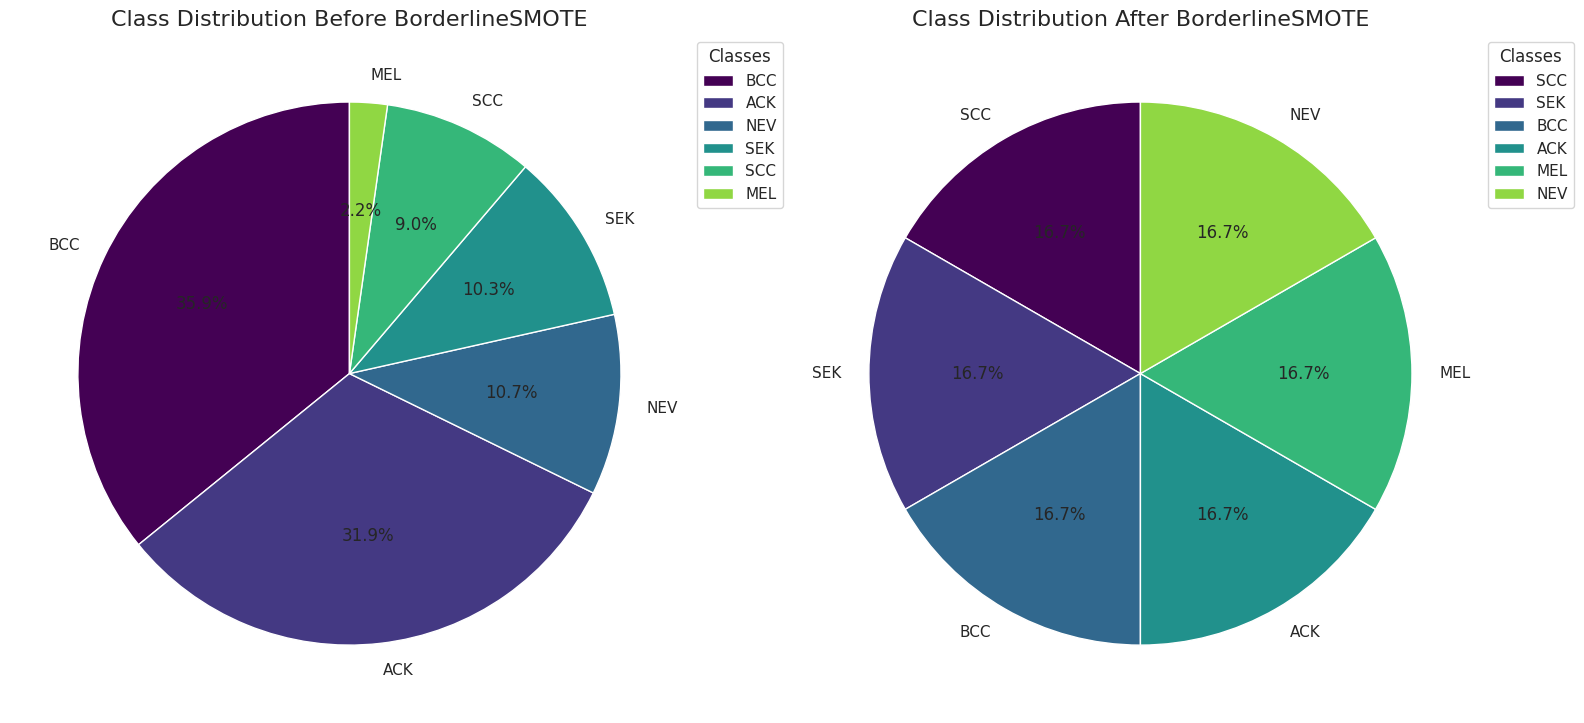

In [31]:
# Define class labels
class_names = {0: 'BCC', 1: 'ACK', 2: 'NEV', 3: 'SEK', 4: 'SCC', 5: 'MEL'}

# Calculate class distributions before and after applying BorderlineSMOTE
original_class_distribution = y_train.value_counts().rename(index=class_names)
balanced_class_distribution = y_train_balanced.value_counts().rename(index=class_names)

# Set up subplots to plot pie charts with distinctive colors
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Define colors using viridis colormap with better differentiation
colors_before = plt.cm.viridis([i / len(original_class_distribution) for i in range(len(original_class_distribution))])
colors_after = plt.cm.viridis([i / len(balanced_class_distribution) for i in range(len(balanced_class_distribution))])

# Plotting the original class distribution as a pie chart with better color differentiation
ax[0].pie(original_class_distribution, labels=original_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=colors_before, wedgeprops={'edgecolor': 'white'})
ax[0].set_title('Class Distribution Before BorderlineSMOTE', fontsize=16)
ax[0].legend(title="Classes", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Plotting the balanced class distribution as a pie chart with better color differentiation
ax[1].pie(balanced_class_distribution, labels=balanced_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=colors_after, wedgeprops={'edgecolor': 'white'})
ax[1].set_title('Class Distribution After BorderlineSMOTE', fontsize=16)
ax[1].legend(title="Classes", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the pie charts with improved aesthetics
plt.tight_layout()
plt.show()

In [7]:
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Histogram GBM": HistGradientBoostingClassifier(random_state=42)
}

In [8]:
# Train and evaluate each model
results = {}

In [10]:
for model_name, model in models.items():
    print(f'Taining {model_name}....')
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Evaluate the model
    results[model_name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_val, y_pred, average='weighted'),
        "F1 Score": f1_score(y_val, y_pred, average='weighted'),
        "ROC AUC": roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr')
    }
    print(f'{model_name} trained....')

Taining XGBoost....
XGBoost trained....
Taining LightGBM....
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83413
[LightGBM] [Info] Number of data points in the train set: 3162, number of used features: 335
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [11]:
# Displaying the results
results_df = pd.DataFrame(results).T
results_df

Accuracy  Precision    Recall  F1 Score   ROC AUC
XGBoost            0.750000   0.746830  0.750000  0.743194  0.920543
LightGBM           0.741848   0.729893  0.741848  0.724729  0.924030
CatBoost           0.750000   0.738390  0.750000  0.740011  0.925515
AdaBoost           0.285326   0.353594  0.285326  0.276465  0.708711
Gradient Boosting  0.690217   0.706294  0.690217  0.694104  0.916706
Histogram GBM      0.747283   0.735049  0.747283  0.735271  0.924950

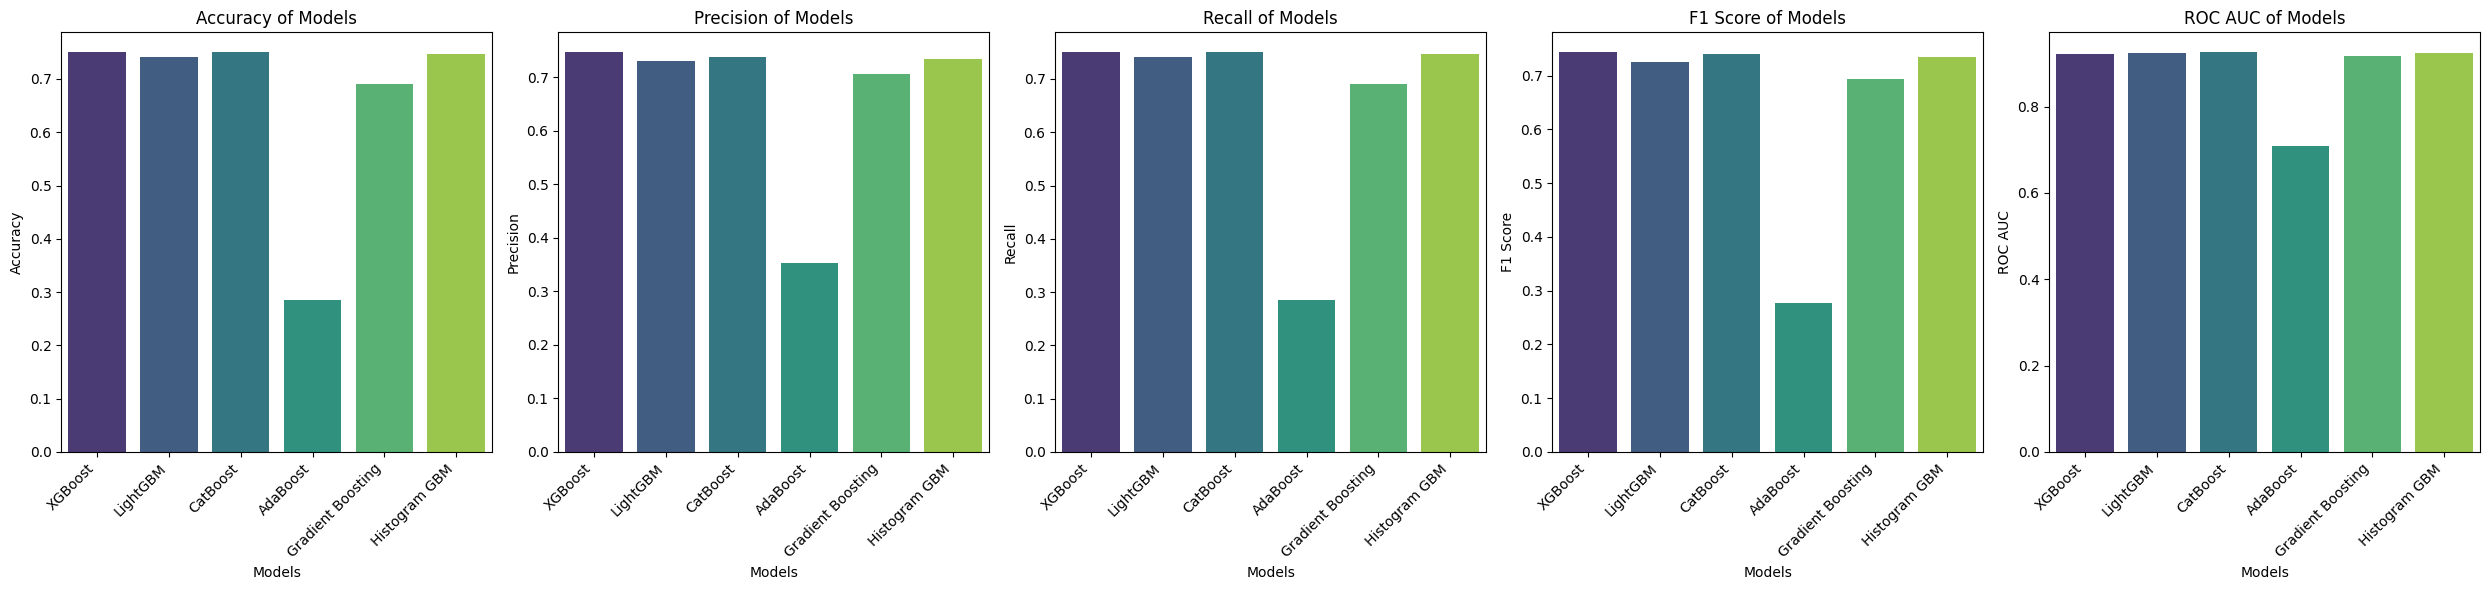

In [12]:
# Extracting metrics for visualization
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

import seaborn as sns

# Set up the plot using seaborn's barplot with viridis palette
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

# Looping through each metric and plotting it using seaborn's barplot with the 'viridis' palette
for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric} of Models')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(results_df.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

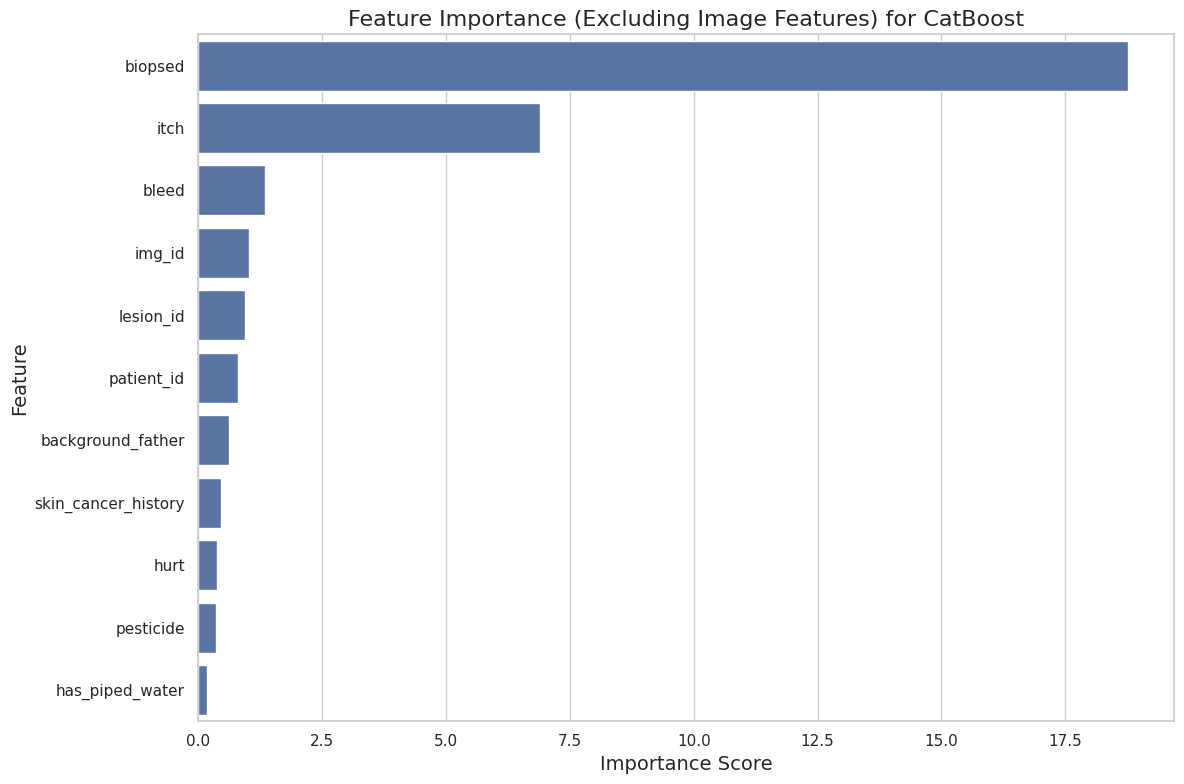

Feature Importances (Excluding Image Features) according to best model: CatBoost
                Feature  Importance
10              biopsed   18.755144
6                  itch    6.905273
8                 bleed    1.341478
9                img_id    1.018371
1             lesion_id    0.946024
0            patient_id    0.804426
2     background_father    0.627300
4   skin_cancer_history    0.451874
7                  hurt    0.370316
3             pesticide    0.353586
5       has_piped_water    0.167203


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for aesthetics
sns.set(style='whitegrid')

# Identify the best model (based on accuracy)
best_model_name = max(model_results, key=lambda x: model_results[x]['Accuracy'])
best_model = models[best_model_name]

# Extract feature importances if available
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Filter out image-based features (e.g., columns like 'pca_feature_0', 'pca_feature_1', etc.)
    importance_df = importance_df[~importance_df['Feature'].str.startswith('pca_feature')]

    # Sort features by their importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plotting the feature importances excluding image features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, color='#4c72b0')
    plt.title(f'Feature Importance (Excluding Image Features) for {best_model_name}', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()

    # Save the feature importance plot as PDF
    plt.savefig('feature_importance_excluding_image_features.pdf', format='pdf', dpi=300)
    plt.show()

    # Print the feature importances
    print("Feature Importances (Excluding Image Features) according to best model:", best_model_name)
    print(importance_df)
else:
    print(f"The best model ({best_model_name}) does not provide feature importances.")


# Medical Insights Extraction

Unique values in 'encoded_class_name' column: ['NEV' 'BCC' 'ACK' 'SEK' 'SCC' 'MEL']
Unique values in 'gender' column: [nan 'FEMALE' 'MALE']
Count of each cancer type by gender:
encoded_class_name  gender
BCC                 MALE      439
                    FEMALE    406
ACK                 FEMALE    153
                    MALE      130
SCC                 MALE      102
                    FEMALE     90
NEV                 FEMALE     49
MEL                 FEMALE     28
SEK                 FEMALE     27
NEV                 MALE       26
MEL                 MALE       24
SEK                 MALE       20
Name: count, dtype: int64


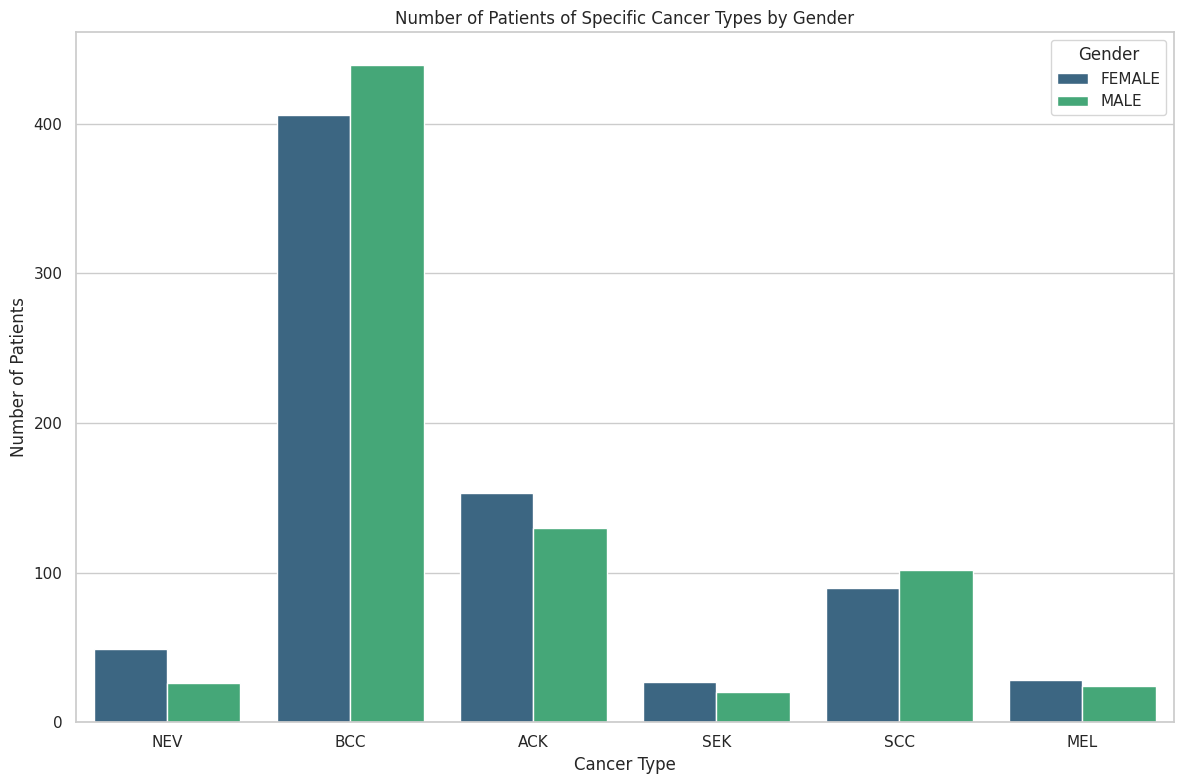


Number of Patients for Each Cancer Type by Gender:
   encoded_class_name  gender  Count
0                 ACK  FEMALE    153
1                 ACK    MALE    130
2                 BCC  FEMALE    406
3                 BCC    MALE    439
4                 MEL  FEMALE     28
5                 MEL    MALE     24
6                 NEV  FEMALE     49
7                 NEV    MALE     26
8                 SCC  FEMALE     90
9                 SCC    MALE    102
10                SEK  FEMALE     27
11                SEK    MALE     20


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the data is loaded properly
data = pd.read_csv('/kaggle/input/skin-cancer/metadata.csv')

# Creating a lookup for diagnostic classes
diagnostic_classes = {'BCC': 0, 'ACK': 1, 'NEV': 2, 'SEK': 3, 'SCC': 4, 'MEL': 5}

# Check if the data contains the encoded_class column
if 'encoded_class' not in data.columns:
    data['encoded_class'] = data['diagnostic'].map(diagnostic_classes)

# Creating the 'encoded_class_name' for better visualization labels
inverse_diagnostic_classes = {v: k for k, v in diagnostic_classes.items()}
data['encoded_class_name'] = data['encoded_class'].map(inverse_diagnostic_classes)

# Verify if 'gender' needs to be mapped as well
# Assuming gender column is encoded as 0 and 1
if data['gender'].dtype != object:
    data['gender'] = data['gender'].map({0: 'Female', 1: 'Male'})

# Debugging outputs to verify data integrity
print("Unique values in 'encoded_class_name' column:", data['encoded_class_name'].unique())
print("Unique values in 'gender' column:", data['gender'].unique())
print("Count of each cancer type by gender:")
print(data[['encoded_class_name', 'gender']].value_counts())

# Plotting the number of patients of each specific cancer type according to gender
plt.figure(figsize=(12, 8))

# Create a countplot to show the distribution of cancer types among genders
sns.countplot(data=data, x='encoded_class_name', hue='gender', palette='viridis')
plt.title('Number of Patients of Specific Cancer Types by Gender')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('number_of_patients_by_cancer_type_and_gender.pdf', format='pdf', dpi=300)

plt.show()

# Additionally, print the number of patients for each cancer type by gender
cancer_gender_counts = data.groupby(['encoded_class_name', 'gender']).size().reset_index(name='Count')
print("\nNumber of Patients for Each Cancer Type by Gender:")
print(cancer_gender_counts)

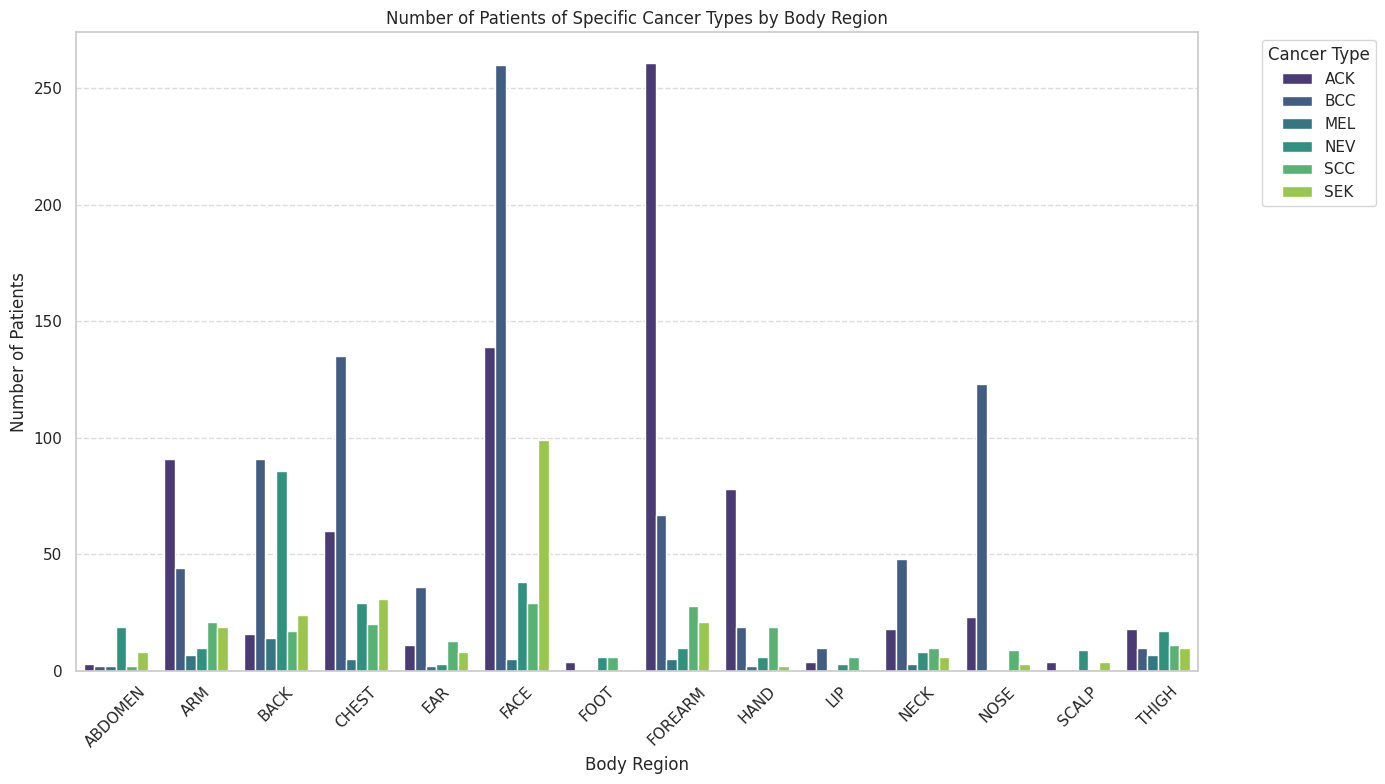


Number of Patients for Each Cancer Type by Body Region:
     region encoded_class_name  Count
0   ABDOMEN                ACK      3
1   ABDOMEN                BCC      2
2   ABDOMEN                MEL      2
3   ABDOMEN                NEV     19
4   ABDOMEN                SCC      2
..      ...                ...    ...
70    THIGH                BCC     10
71    THIGH                MEL      7
72    THIGH                NEV     17
73    THIGH                SCC     11
74    THIGH                SEK     10

[75 rows x 3 columns]


In [15]:
# Group the data to count the number of patients for each cancer type by body region
cancer_body_region_counts = data.groupby(['region', 'encoded_class_name']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))

# Create a bar plot for the number of patients of each specific cancer type according to body region
sns.barplot(data=cancer_body_region_counts, x='region', y='Count', hue='encoded_class_name', palette='viridis')
plt.title('Number of Patients of Specific Cancer Types by Body Region')
plt.xlabel('Body Region')
plt.ylabel('Number of Patients')
plt.legend(title='Cancer Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend for better clarity
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to enhance readability
plt.tight_layout()

# Save the figure as a high-resolution PDF
plt.savefig('number_of_patients_by_cancer_type_and_body_region.pdf', format='pdf', dpi=300)

# Show the plot
plt.show()

# Additionally, print the number of patients for each cancer type by body region
print("\nNumber of Patients for Each Cancer Type by Body Region:")
print(cancer_body_region_counts)


/tmp/ipykernel_30/2923597069.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_diagnostic_counts = data.groupby(['age_group', 'diagnostic']).size().reset_index(name='count')
/tmp/ipykernel_30/2923597069.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_diagnostic_counts.groupby('age_group')['count'].transform('sum')
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

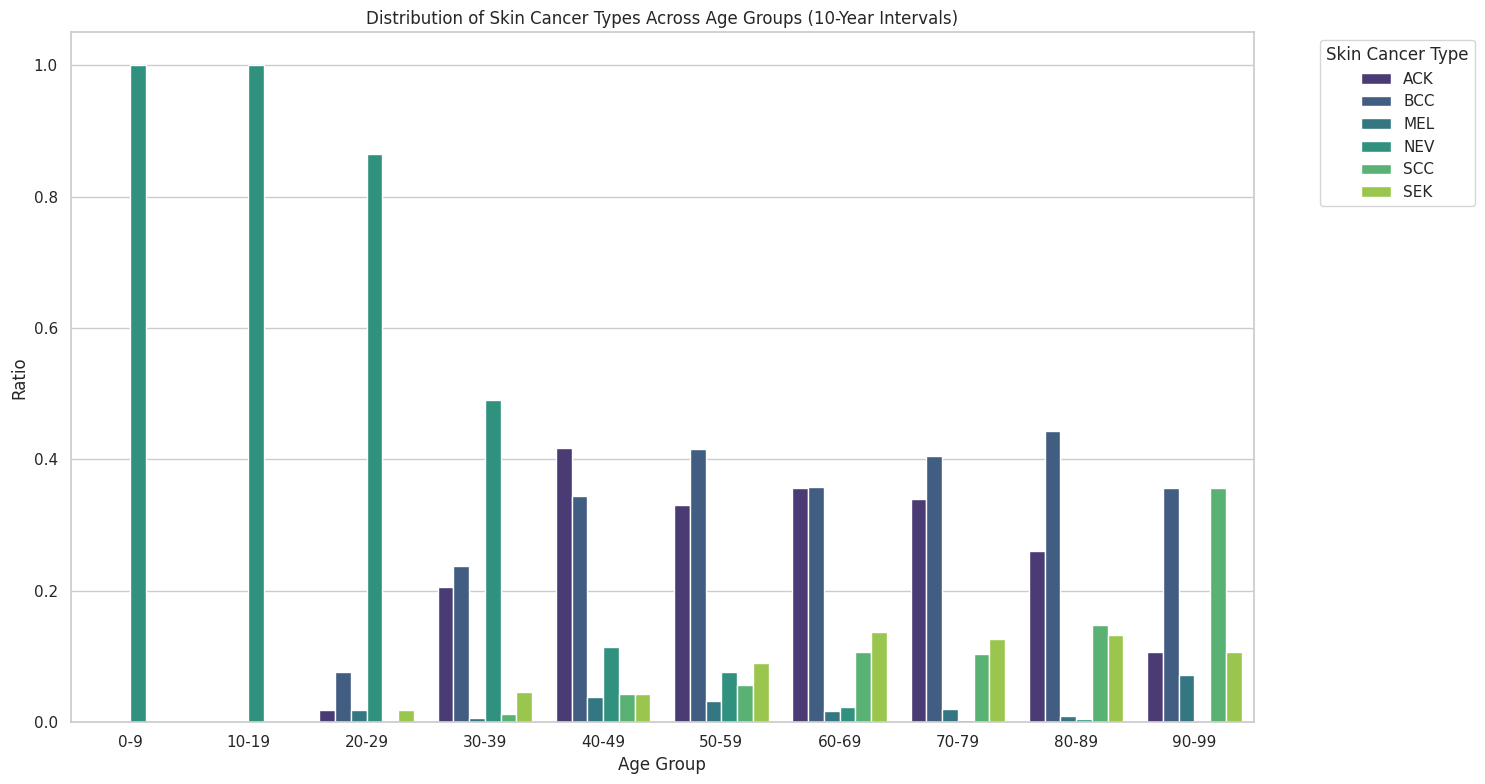

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata file
data = pd.read_csv('/kaggle/input/skin-cancer/metadata.csv')

# Drop rows with missing age or diagnostic values
data = data.dropna(subset=['age', 'diagnostic'])

# Define age groups with 10-year intervals
bins = list(range(0, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Create a new column for age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Group by age group and diagnostic type, then count occurrences
age_diagnostic_counts = data.groupby(['age_group', 'diagnostic']).size().reset_index(name='count')

# Normalize the counts to get ratios within each age group
age_group_totals = age_diagnostic_counts.groupby('age_group')['count'].transform('sum')
age_diagnostic_counts['ratio'] = age_diagnostic_counts['count'] / age_group_totals

# Plotting with Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(
    data=age_diagnostic_counts,
    x='age_group',
    y='ratio',
    hue='diagnostic',
    palette='viridis'
)

# Customizing the plot
plt.title('Distribution of Skin Cancer Types Across Age Groups (10-Year Intervals)')
plt.xlabel('Age Group')
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.legend(title='Skin Cancer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure as a high-resolution PDF
plt.savefig('/kaggle/working/skin_cancer_age_groups_10yr_viridis.pdf', dpi=300, format='pdf')
plt.show()


In [1]:
age_diagnostic_counts

age_group diagnostic  count     ratio
0        0-9        ACK      0  0.000000
1        0-9        BCC      0  0.000000
2        0-9        MEL      0  0.000000
3        0-9        NEV      7  1.000000
4        0-9        SCC      0  0.000000
5        0-9        SEK      0  0.000000
6      10-19        ACK      0  0.000000
7      10-19        BCC      0  0.000000
8      10-19        MEL      0  0.000000
9      10-19        NEV     33  1.000000
10     10-19        SCC      0  0.000000
11     10-19        SEK      0  0.000000
12     20-29        ACK      1  0.019231
13     20-29        BCC      4  0.076923
14     20-29        MEL      1  0.019231
15     20-29        NEV     45  0.865385
16     20-29        SCC      0  0.000000
17     20-29        SEK      1  0.019231
18     30-39        ACK     31  0.205298
19     30-39        BCC     36  0.238411
20     30-39        MEL      1  0.006623
21     30-39        NEV     74  0.490066
22     30-39        SCC      2  0.013245
23     30-39        SEK      7  0.046358
24     40-49        ACK     98  0.417021
25     40-49        BCC     81  0.344681
26     40-49        MEL      9  0.038298
27     40-49        NEV     27  0.114894
28     40-49        SCC     10  0.042553
29     40-49        SEK     10  0.042553
30     50-59        ACK    183  0.330325
31     50-59        BCC    230  0.415162
32     50-59        MEL     18  0.032491
33     50-59        NEV     42  0.075812
34     50-59        SCC     31  0.055957
35     50-59        SEK     50  0.090253
36     60-69        ACK    194  0.356618
37     60-69        BCC    195  0.358456
38     60-69        MEL      9  0.016544
39     60-69        NEV     13  0.023897
40     60-69        SCC     58  0.106618
41     60-69        SEK     75  0.137868
42     70-79        ACK    167  0.340122
43     70-79        BCC    199  0.405295
44     70-79        MEL     10  0.020367
45     70-79        NEV      2  0.004073
46     70-79        SCC     51  0.103870
47     70-79        SEK     62  0.126273
48     80-89        ACK     53  0.261084
49     80-89        BCC     90  0.443350
50     80-89        MEL      2  0.009852
51     80-89        NEV      1  0.004926
52     80-89        SCC     30  0.147783
53     80-89        SEK     27  0.133005
54     90-99        ACK      3  0.107143
55     90-99        BCC     10  0.357143
56     90-99        MEL      2  0.071429
57     90-99        NEV      0  0.000000
58     90-99        SCC     10  0.357143
59     90-99        SEK      3  0.107143

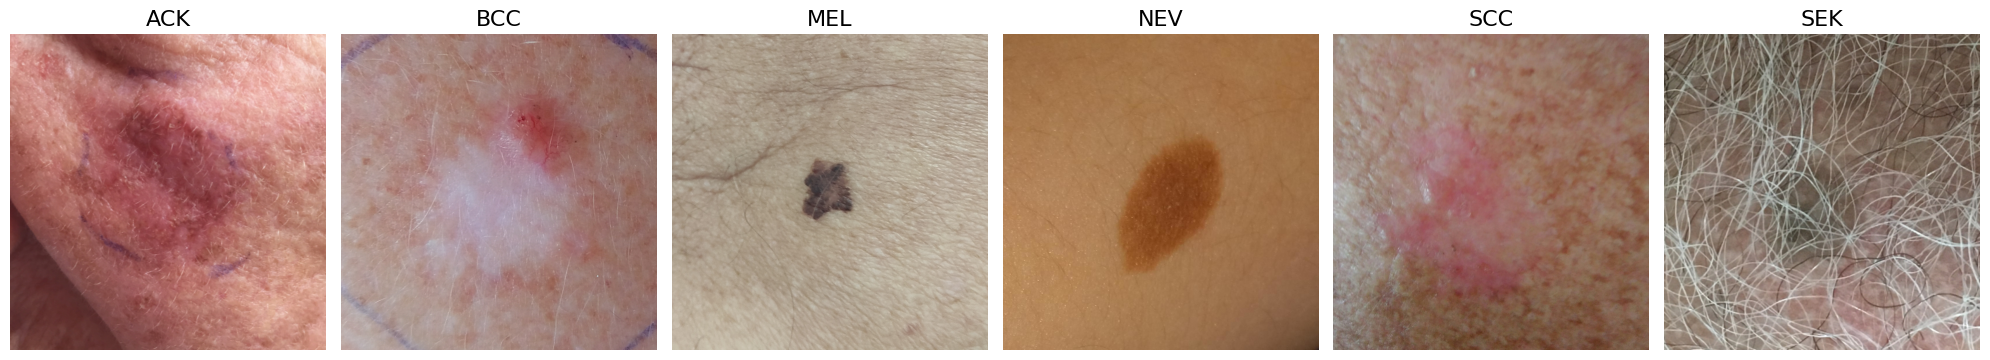

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Load the metadata file
data = pd.read_csv('/kaggle/input/skin-cancer/metadata.csv')

# Create full image links
data['image_path'] = '/kaggle/working/full_image/' + data['img_id']

# Get one sample image for each type of diagnostic
sample_images = data.groupby('diagnostic').first().reset_index()

# Plotting the images
plt.figure(figsize=(20, 5))  # Adjusted to accommodate a single row display

for i, row in enumerate(sample_images.itertuples(), start=1):
    image_path = row.image_path
    diagnostic = row.diagnostic

    # Read the image using cv2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.subplot(1, len(sample_images), i)  # Adjusted to have a single row with as many columns as images
    plt.imshow(image)
    plt.title(diagnostic, fontsize=16)  # Increased the font size for the title
    plt.axis('off')

plt.tight_layout()

# Save the figure as a high-resolution PDF
plt.savefig('/kaggle/working/skin_cancer_samples.pdf', dpi=300, format='pdf')
plt.show()


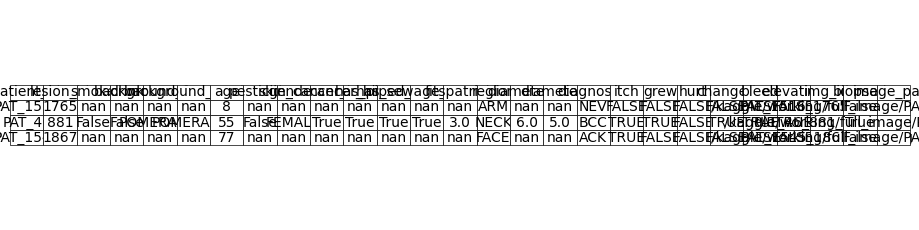

In [7]:
df = data.head(3)
# Plotting the DataFrame as a Table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')  # Turn off the axis

# Prepare data for the table
column_labels = df.columns.tolist()  # Get column labels
cell_data = df.values.tolist()       # Get data as a list of lists

# Create table using Matplotlib
table = tbl.table(ax, cellText=cell_data, colLabels=column_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

# Customize table
for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')  # Add borders
    cell.set_linewidth(0.5)

# Annotate the table with arrows
for i, col in enumerate(df.columns):
    # Arrow pointing to the column name
    plt.annotate(
        col, 
        xy=(i / len(df.columns), 1.2),  # Coordinates above the column
        xytext=(i / len(df.columns), 1.35),  # Offset for the arrow start point
        arrowprops=dict(facecolor='red', arrowstyle='->'),
        ha='center', fontsize=10, color='red'
    )

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1)

# Show the plot
plt.show()

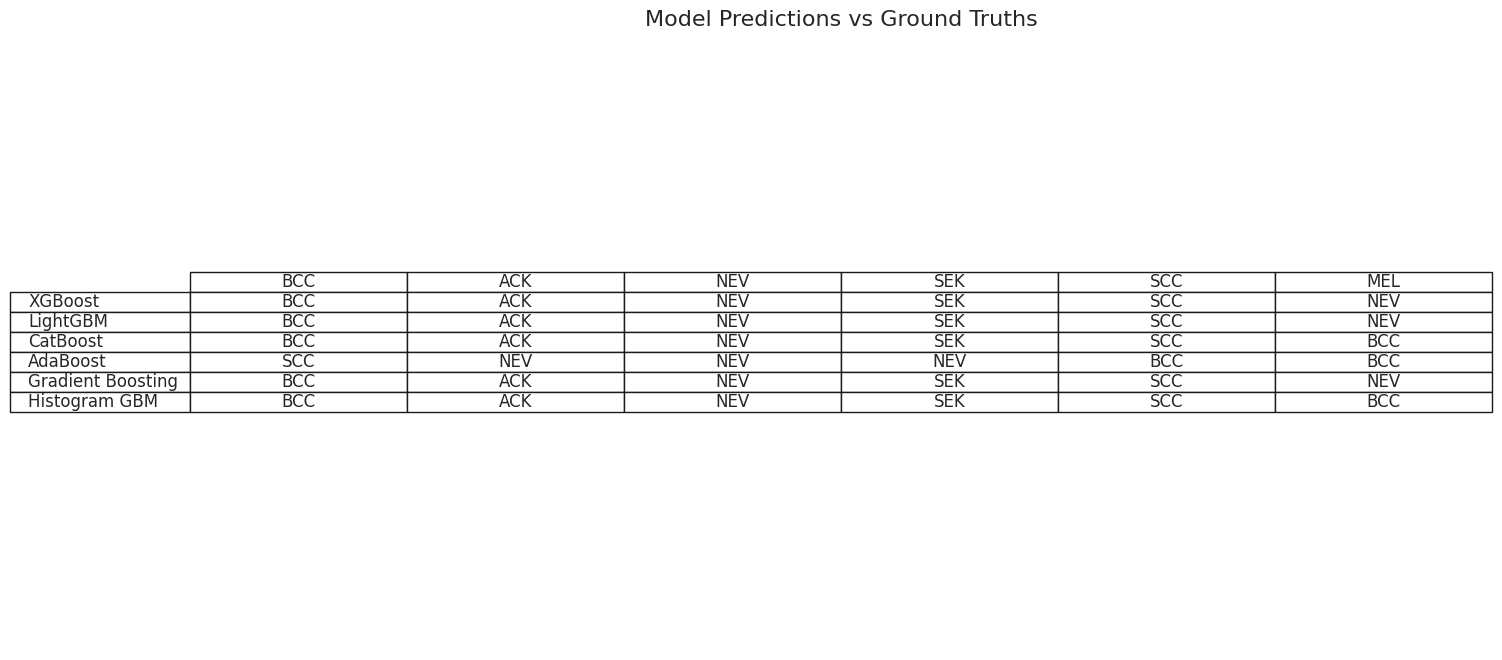

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the test data
test_data = pd.read_csv('/kaggle/working/test_data_with_pca_features.csv')

# Class mapping
class_mapping = {0: 'BCC', 1: 'ACK', 2: 'NEV', 3: 'SEK', 4: 'SCC', 5: 'MEL'}

# Map the encoded classes to their names
test_data['class_name'] = test_data['encoded_class'].map(class_mapping)

# Select one sample from each class (6 samples in total)
selected_samples = test_data.groupby('encoded_class').first().reset_index()

# Extract features, labels, and image addresses
X_selected = selected_samples.drop(columns=['encoded_class', 'image_address', 'class_name'])
y_selected = selected_samples['encoded_class']
image_addresses = selected_samples['image_address']
ground_truth_labels = selected_samples['class_name']

# Initialize predictions dictionary
predictions = {}

# Ensure that the 'models' dictionary is defined in your environment
try:
    models_list = list(models.keys())

    # Make predictions for each model
    for model_name, model in models.items():
        y_pred = model.predict(X_selected)
        predictions[model_name] = [class_mapping[label] for label in y_pred.flatten()]

except NameError:
    print("Error: 'models' dictionary is not defined. Please load your trained models and try again.")
    raise

# Prepare the data for visualization
models_list = list(models.keys())
ground_truths = [class_mapping[label] for label in y_selected]

# Construct a DataFrame for comparison
comparison_df = pd.DataFrame(predictions, index=ground_truths).T

# Create a text-based matrix plot
fig, ax = plt.subplots(figsize=(14, 8))

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table with predictions
table = ax.table(cellText=comparison_df.values, rowLabels=models_list, colLabels=ground_truths, cellLoc='center', loc='center')

# Enhance the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Set a title
plt.title("Model Predictions vs Ground Truths", fontsize=16)
plt.show()


In [18]:
comparison_df

BCC  ACK  NEV  SEK  SCC  MEL
XGBoost            BCC  ACK  NEV  SEK  SCC  NEV
LightGBM           BCC  ACK  NEV  SEK  SCC  NEV
CatBoost           BCC  ACK  NEV  SEK  SCC  BCC
AdaBoost           SCC  NEV  NEV  NEV  BCC  BCC
Gradient Boosting  BCC  ACK  NEV  SEK  SCC  NEV
Histogram GBM      BCC  ACK  NEV  SEK  SCC  BCC

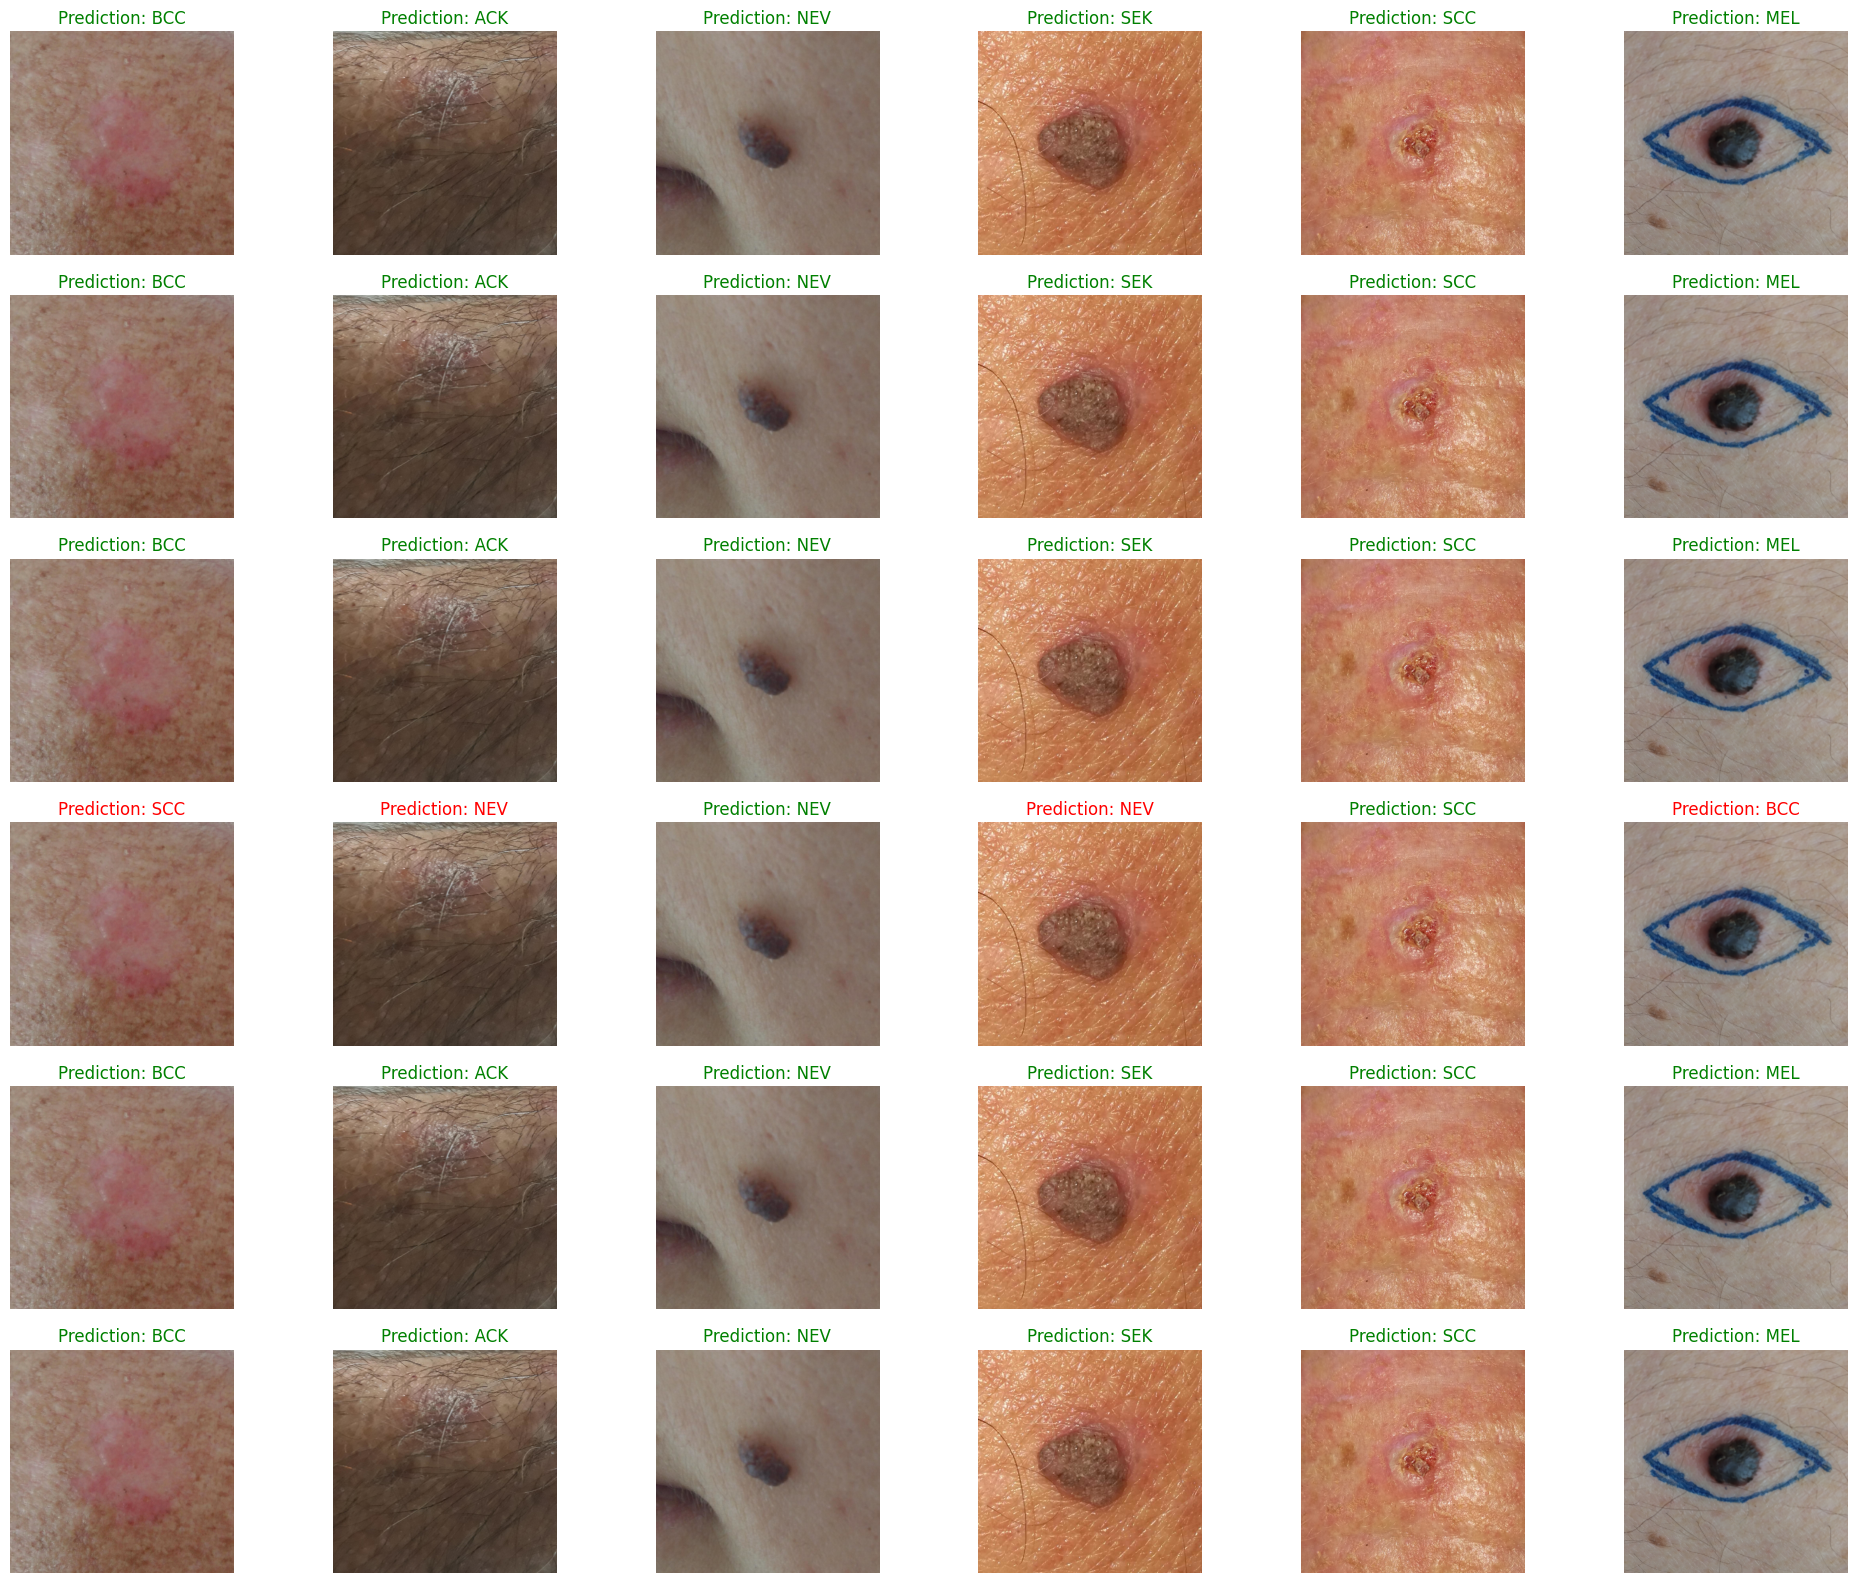

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Reload the dataset and reinitialize everything
test_data = pd.read_csv('/kaggle/working/train_data_with_pca_features.csv')

# Define class mapping
class_mapping = {0: 'BCC', 1: 'ACK', 2: 'NEV', 3: 'SEK', 4: 'SCC', 5: 'MEL'}

# Map encoded classes to class names
test_data['class_name'] = test_data['encoded_class'].map(class_mapping)

# Select one sample per class
selected_samples = test_data.groupby('encoded_class').last().reset_index()

# Extract features, labels, and image addresses
X_selected = selected_samples.drop(columns=['encoded_class', 'image_address', 'class_name'])
y_selected = selected_samples['encoded_class']
image_addresses = selected_samples['image_address']
ground_truth_labels = selected_samples['class_name']

# Reinitialize model predictions
try:
    models_list = list(models.keys())
    predictions = {}

    # Make predictions for each model
    for model_name, model in models.items():
        y_pred = model.predict(X_selected)
        predictions[model_name] = [class_mapping[label] for label in y_pred.flatten()]

except NameError:
    print("Error: 'models' dictionary is not defined. Please load your trained models and try again.")
    raise

# Define ground truths
ground_truths = [class_mapping[label] for label in y_selected]

# Improved visualization with images, color-coded predictions, and labels
fig, axes = plt.subplots(len(models_list), len(ground_truths), figsize=(20, 16))
axes = axes.flatten()

# Define colors for correct and incorrect predictions
correct_color = "green"
incorrect_color = "red"

# Iterate through models and ground truth classes
for i, model_name in enumerate(models_list):
    for j, ground_truth in enumerate(ground_truths):
        index = i * len(ground_truths) + j

        # Load the image
        img_path = image_addresses.iloc[j]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        ax = axes[index]
        ax.imshow(img)
        ax.axis('off')

        # Get prediction and determine correctness
        prediction = predictions[model_name][j]
        is_correct = prediction == ground_truth
        color = correct_color if is_correct else incorrect_color

        # Set the prediction as the title with color-coded text
        ax.set_title(f"Prediction: {prediction}", fontsize=12, color=color)
        ax.set_xlabel(f"Ground Truth: {ground_truth}", fontsize=10)

# Adjust layout and add main title
plt.tight_layout()
# plt.suptitle("Model Predictions vs Ground Truths (Color-Coded Feedback)", fontsize=20)
plt.show()
